# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

EPOCHS_AE = 30#30
PATIENCE_AE = 0#10
LIST_UNITS_AE = [512]
LIST_UNITS_ENC_AE = [32]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 30#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [512]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_19615/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
91865  1700090700000   2048.03   2050.03  2048.03    2049.88    618.5052   
91866  1700091000000   2049.88   2055.00  2049.87    2055.00    825.9691   
91867  1700091300000   2055.00   2056.66  2052.87    2056.66    813.5290   
91868  1700091600000   2056.65   2060.00  2056.31    2056.75   1027.9829   
91869  1700091900000   2056.74   2057.30  2056.38    2056.38     85.2793   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1736.899212       1736.445752   
1      2023-01-01 00:05:00       1736.899212       1736.445752   
2      2023-01-01 00:10:00       1736.899212       1736.445752   
3      2023-01-01 00:15:00       1736.899212       1736.445752   
4      2023-01-01 00:20:00       1736.899212       1736.445752   
...                    ...               ...               ...   
91865  2023-11-15 23:25:00       2044.872500       2032.115000   
91866  2023-11-15 23:30:00       2044.245000       2032.115000   
91867  2023-11-15 23:35:00       2044.245000       2032.405000   
91868  2023-11-15 23:40:00       2044.740000       2032.650000   
91869  2023-11-15 23:45:00       2045.267500       2032.650000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
91865        2048.790  ...   NaN         NaN            NaN           NaN   
91866        2049.775  ...   NaN         NaN            NaN           NaN   
91867        2049.775  ...   NaN         NaN            NaN           NaN   
91868        2049.775  ...   NaN         NaN            NaN           NaN   
91869        2050.975  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
91865               NaN         0.0               NaN         0.0      0.0   
91866               NaN         0.0               NaN         0.0      0.0   
91867               NaN         0.0               NaN         0.0      0.0   
91868               NaN         0.0               NaN         0.0      0.0   
91869               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
91865   NaN  
91866   NaN  
91867   NaN  
91868   NaN  
91869   NaN  

[91870 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              91830
Event               91830
Country             91830
keep                91830
date                91830
Length: 65, dtype: int64

on 91870 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
91865  1700090700000   2048.03   2050.03  2048.03    2049.88    618.5052   
91866  1700091000000   2049.88   2055.00  2049.87    2055.00    825.9691   
91867  1700091300000   2055.00   2056.66  2052.87    2056.66    813.5290   
91868  1700091600000   2056.65   2060.00  2056.31    2056.75   1027.9829   
91869  1700091900000   2056.74   2057.30  2056.38    2056.38     85.2793   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1736.899212       1736.445752   
1      2023-01-01 00:05:00       1736.899212       1736.445752   
2      2023-01-01 00:10:00       1736.899212       1736.445752   
3      2023-01-01 00:15:00       1736.899212       1736.445752   
4      2023-01-01 00:20:00       1736.899212       1736.445752   
...                    ...               ...               ...   
91865  2023-11-15 23:25:00       2044.872500       2032.115000   
91866  2023-11-15 23:30:00       2044.245000       2032.115000   
91867  2023-11-15 23:35:00       2044.245000       2032.405000   
91868  2023-11-15 23:40:00       2044.740000       2032.650000   
91869  2023-11-15 23:45:00       2045.267500       2032.650000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
91865        2048.790  ...   NaN         NaN            NaN           NaN   
91866        2049.775  ...   NaN         NaN            NaN           NaN   
91867        2049.775  ...   NaN         NaN            NaN           NaN   
91868        2049.775  ...   NaN         NaN            NaN           NaN   
91869        2050.975  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
91865               NaN         0.0               NaN         0.0      0.0   
91866               NaN         0.0               NaN         0.0      0.0   
91867               NaN         0.0               NaN         0.0      0.0   
91868               NaN         0.0               NaN         0.0      0.0   
91869               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
91865                  NaN  
91866                  NaN  
91867                  NaN  
91868                  NaN  
91869                  NaN  

[91870 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       129
delta_event_real    129
delta_event_pred    129
Previous_num        129
Actual_num          129
Event               129
Date                129
Previous            129
Consensus           129
Actual              129
Country             129
Time (ET)           129
keep                129
date                129
dtype: int64

on 91870 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
91865   2048.03   2050.03  2048.03    2049.88    618.5052   
91866   2049.88   2055.00  2049.87    2055.00    825.9691   
91867   2055.00   2056.66  2052.87    2056.66    813.5290   
91868   2056.65   2060.00  2056.31    2056.75   1027.9829   
91869   2056.74   2057.30  2056.38    2056.38     85.2793   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1736.899212       1736.445752   
1      2023-01-01 00:05:00       1736.899212       1736.445752   
2      2023-01-01 00:10:00       1736.899212       1736.445752   
3      2023-01-01 00:15:00       1736.899212       1736.445752   
4      2023-01-01 00:20:00       1736.899212       1736.445752   
...                    ...               ...               ...   
91865  2023-11-15 23:25:00       2044.872500       2032.115000   
91866  2023-11-15 23:30:00       2044.245000       2032.115000   
91867  2023-11-15 23:35:00       2044.245000       2032.405000   
91868  2023-11-15 23:40:00       2044.740000       2032.650000   
91869  2023-11-15 23:45:00       2045.267500       2032.650000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
91865        2048.790         2053.805  ...  1947.088569  1785.185089   
91866        2049.775         2051.895  ...  1947.114701  1785.202816   
91867        2049.775         2051.660  ...  1947.135730  1785.218141   
91868        2049.775         2053.330  ...  1947.156126  1785.237990   
91869        2050.975         2053.330  ...  1947.168783  1785.243352   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
91865  1742.952999  1857.847134   1733.979622          1.891977  0.154107   
91866  1742.961701  1858.409931   1733.981836          1.922601  0.156213   
91867  1742.969407  1858.764144   1733.984032          1.932502  0.156893   
91868  1742.980151  1859.672420   1733.986826          1.932996  0.156929   
91869  1742.979833  1860.129033   1733.987057          1.930751  0.156777   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.204764e+08      432042.0       17.948732  
1      1.204764e+08      432042.0       17.948732  
2      1.204764e+08      432042.0       17.948732  
3      1.204764e+08      432042.0       17.948732  
4      1.204764e+08      432042.0       17.948732  
...             ...           ...             ...  
91865  1.202560e+08      411868.0       16.937596  
91866  1.202560e+08      411868.0       16.937596  
91867  1.202560e+08      411868.0       16.937596  
91868  1.202560e+08      411868.0       16.937596  
91869  1.202560e+08      411868.0       16.937596  

[91870 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
91865  4.526  4502.879883  104.378998
91866  4.526  4502.879883  104.378998
91867  4.526  4502.879883  104.378998
91868  4.526  4502.879883  104.378998
91869  4.526  4502.879883  104.378998

[91870 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

91870

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

91411

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
91865  1700090700000   2048.03   2050.03  2048.03    2049.88    618.5052   
91866  1700091000000   2049.88   2055.00  2049.87    2055.00    825.9691   
91867  1700091300000   2055.00   2056.66  2052.87    2056.66    813.5290   
91868  1700091600000   2056.65   2060.00  2056.31    2056.75   1027.9829   
91869  1700091900000   2056.74   2057.30  2056.38    2056.38     85.2793   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1736.899212       1736.445752   
1      2023-01-01 00:05:00       1736.899212       1736.445752   
2      2023-01-01 00:10:00       1736.899212       1736.445752   
3      2023-01-01 00:15:00       1736.899212       1736.445752   
4      2023-01-01 00:20:00       1736.899212       1736.445752   
...                    ...               ...               ...   
91865  2023-11-15 23:25:00       2044.872500       2032.115000   
91866  2023-11-15 23:30:00       2044.245000       2032.115000   
91867  2023-11-15 23:35:00       2044.245000       2032.405000   
91868  2023-11-15 23:40:00       2044.740000       2032.650000   
91869  2023-11-15 23:45:00       2045.267500       2032.650000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
91865        2048.790  ...         NaN            NaN           NaN   
91866        2049.775  ...         NaN            NaN           NaN   
91867        2049.775  ...         NaN            NaN           NaN   
91868        2049.775  ...         NaN            NaN           NaN   
91869        2050.975  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
91865               NaN         0.0               NaN         0.0      0.0   
91866               NaN         0.0               NaN         0.0      0.0   
91867               NaN         0.0               NaN         0.0      0.0   
91868               NaN         0.0               NaN         0.0      0.0   
91869               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
91865                  NaN  False  
91866                  NaN  False  
91867                  NaN  False  
91868                  NaN  False  
91869                  NaN  False  

[91870 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
91407  1699953300000   2058.49   2058.57  2055.80    2056.15    758.4089   
91408  1699953600000   2056.15   2056.49  2053.70    2053.92   1244.6731   
91409  1699953900000   2053.92   2055.79  2053.01    2053.42   1266.5329   
91410  1699954200000   2053.42   2053.43  2050.12    2052.27   1624.0066   
91411  1699954500000   2052.26   2054.15  2049.50    2053.77   1650.5180   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1736.899212       1736.445752   
1      2023-01-01 00:05:00       1736.899212       1736.445752   
2      2023-01-01 00:10:00       1736.899212       1736.445752   
3      2023-01-01 00:15:00       1736.899212       1736.445752   
4      2023-01-01 00:20:00       1736.899212       1736.445752   
...                    ...               ...               ...   
91407  2023-11-14 09:15:00       2059.467500       2056.285000   
91408  2023-11-14 09:20:00       2059.087500       2056.285000   
91409  2023-11-14 09:25:00       2059.272500       2056.285000   
91410  2023-11-14 09:30:00       2059.272500       2056.285000   
91411  2023-11-14 09:35:00       2059.272500       2056.285000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
91407        2060.300  ...         4.0            4.1           4.1   
91408        2059.250  ...         4.0            4.1           4.1   
91409        2058.905  ...         4.0            4.1           4.1   
91410        2057.460  ...         4.0            4.1           4.1   
91411        2057.150  ...         4.0            4.1           4.1   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
91407               0.0         0.0               0.1         0.0      0.0   
91408               0.0         0.0               0.1         0.0      0.0   
91409               0.0         0.0               0.1         0.0      0.0   
91410               0.0         0.0               0.1         0.0      0.0   
91411               0.0         0.0               0.1         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
91407  2023-11-14 13:00:00   True  
91408  2023-11-14 13:00:00   True  
91409  2023-11-14 13:00:00   True  
91410  2023-11-14 13:00:00   True  
91411  2023-11-14 13:00:00   True  

[91412 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
91412  1699954800000   2053.78   2054.55  2050.56    2052.36    843.5156   
91413  1699955100000   2052.36   2053.27  2048.26    2048.77   1082.5534   
91414  1699955400000   2048.77   2051.23  2047.35    2049.30    853.8551   
91415  1699955700000   2049.30   2049.92  2047.32    2047.44    690.6633   
91416  1699956000000   2047.45   2048.32  2043.45    2043.82   1443.2950   
...              ...       ...       ...      ...        ...         ...   
91865  1700090700000   2048.03   2050.03  2048.03    2049.88    618.5052   
91866  1700091000000   2049.88   2055.00  2049.87    2055.00    825.9691   
91867  1700091300000   2055.00   2056.66  2052.87    2056.66    813.5290   
91868  1700091600000   2056.65   2060.00  2056.31    2056.75   1027.9829   
91869  1700091900000   2056.74   2057.30  2056.38    2056.38     85.2793   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
91412  2023-11-14 09:40:00         2059.2725          2056.285   
91413  2023-11-14 09:45:00         2059.2725          2056.285   
91414  2023-11-14 09:50:00         2059.7025          2056.285   
91415  2023-11-14 09:55:00         2059.7025          2056.285   
91416  2023-11-14 10:00:00         2059.7025          2056.285   
...                    ...               ...               ...   
91865  2023-11-15 23:25:00         2044.8725          2032.115   
91866  2023-11-15 23:30:00         2044.2450          2032.115   
91867  2023-11-15 23:35:00         2044.2450          2032.405   
91868  2023-11-15 23:40:00         2044.7400          2032.650   
91869  2023-11-15 23:45:00         2045.2675          2032.650   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
91412        2057.150  ...         4.0            4.1           4.1   
91413        2056.530  ...         4.0            4.1           4.1   
91414        2056.075  ...         4.0            4.1           4.1   
91415        2056.060  ...         4.0            4.1           4.1   
91416        2054.125  ...         4.0            4.1           4.1   
...               ...  ...         ...            ...           ...   
91865        2048.790  ...         NaN            NaN           NaN   
91866        2049.775  ...         NaN            NaN           NaN   
91867        2049.775  ...         NaN            NaN           NaN   
91868        2049.775  ...         NaN            NaN           NaN   
91869        2050.975  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
91412               0.0         0.0               0.1         0.0      0.0   
91413               0.0         0.0               0.1         0.0      0.0   
91414               0.0         0.0               0.1         0.0      0.0   
91415               0.0         0.0               0.1         0.0      0.0   
91416               0.0         0.0               0.1         0.0      0.0   
...                 ...         ...               ...         ...      ...   
91865               NaN         0.0               NaN         0.0      0.0   
91866               NaN         0.0               NaN         0.0      0.0   
91867               NaN         0.0               NaN         0.0      0.0   
91868               NaN         0.0               NaN         0.0      0.0   
91869               NaN         0.0               NaN         0.0      0.0   

                      date  train  
91412  2023-11-14 13:00:00  False  
91413  2023-11-14 13:00:00  False  
91414  2023-11-14 13:00:00  False  
91415  2023-11-14 13:00:00  False  
91416  2023-11-14 13:00:00  False  
...                    ...    ...  
91865                  NaN  False  
91866                  NaN  False  
91867                  NaN  False  
91868                  NaN  False  
91869                  NaN  False  

[458 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(91325, 72, 102) (91325, 15)
(371, 72, 102) (371, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([0.99944259, 1.00002908, 0.99861376, 0.99860891, 0.99840534,
       0.9978964 , 0.99913723, 0.99960739, 0.99847319, 0.99836171,
       0.99775099, 0.99661679, 0.99553591, 0.99529356, 0.99473615])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00149483, 1.00131041, 1.00075227, ..., 0.99905845, 0.99792276,
        0.99684047],
       [0.99981585, 0.99925854, 0.99984492, ..., 0.99643326, 0.99535258,
        0.99511027],
       [0.99944259, 1.00002908, 0.99861376, ..., 0.99553591, 0.99529356,
        0.99473615]])

In [39]:
seq_y

array([0.99944259, 1.00002908, 0.99861376, 0.99860891, 0.99840534,
       0.9978964 , 0.99913723, 0.99960739, 0.99847319, 0.99836171,
       0.99775099, 0.99661679, 0.99553591, 0.99529356, 0.99473615])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00149483, 1.00131041, 1.00075227, ..., 0.99905845, 0.99792276,
        0.99684047],
       [0.99981585, 0.99925854, 0.99984492, ..., 0.99643326, 0.99535258,
        0.99511027],
       [0.99944259, 1.00002908, 0.99861376, ..., 0.99553591, 0.99529356,
        0.99473615]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(91325, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(91325, 72, 102) (91325, 15)
(371, 72, 102) (371, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00149483, 1.00131041, 1.00075227, ..., 0.99905845, 0.99792276,
        0.99684047],
       [0.99981585, 0.99925854, 0.99984492, ..., 0.99643326, 0.99535258,
        0.99511027],
       [0.99944259, 1.00002908, 0.99861376, ..., 0.99553591, 0.99529356,
        0.99473615]])

In [47]:
np.mean(y_train_sca)

-3.2035190122454864e-07

In [48]:
np.std(y_train_sca)

0.9998689843593567

In [49]:
np.mean(y_test_sca)

0.014620399954584652

In [50]:
np.std(y_test_sca)

1.3477331351331998

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1736.899212       1736.445752   
1    1195.38   1196.31   1196.69  1194.90       1736.899212       1736.445752   
2    1194.55   1195.38   1195.81  1194.55       1736.899212       1736.445752   
3    1195.98   1194.55   1195.98  1194.31       1736.899212       1736.445752   
4    1196.06   1195.98   1196.37  1195.97       1736.899212       1736.445752   
5    1196.61   1196.06   1196.70  1196.06       1736.899212       1736.445752   
6    1194.36   1196.62   1196.62  1193.72       1736.899212       1736.445752   
7    1194.22   1194.37   1194.43  1192.72       1736.899212       1736.445752   
8    1193.64   1194.22   1194.22  1193.02       1736.899212       1736.445752   
9    1194.64   1193.64   1195.06  1193.63       1736.899212       1736.445752   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1738.582639   
1         1194.71          1194.71           1738.582639   
2         1194.71          1194.71           1738.582639   
3         1194.71          1194.71           1738.582639   
4         1194.71          1194.71           1738.582639   
5         1194.71          1194.71           1738.582639   
6         1194.71          1194.71           1738.582639   
7         1194.71          1194.71           1738.582639   
8         1194.71          1194.71           1738.582639   
9         1194.71          1194.71           1738.582639   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   
1           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   
2           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   
3           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   
4           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   
5           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   
6           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   
7           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   
8           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   
9           1731.424018  ...  1.204764e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(6575400, 102)

In [57]:
X_train[:,-1,:].shape

(91325, 102)

In [58]:
X_test[:,-1,:].shape

(371, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.021385 -0.004278 -0.057551  0.088938         -0.035030   
1       0.021385 -0.032204 -0.069633  0.060937         -0.068215   
2       0.021385  0.031656 -0.047491  0.096953         -0.061758   
3       0.021385  0.113551  0.022024  0.103947          0.007713   
4       0.021385 -0.058160 -0.067620  0.035912         -0.034470   
...          ...       ...       ...       ...               ...   
91691   0.021385  0.063665 -0.027702  0.036439         -0.402553   
91692   0.021385 -0.348647 -0.036631 -0.260020         -0.541374   
91693   0.021385  0.318322  0.228555  0.079732         -0.294357   
91694   0.021385 -0.056950 -0.033632 -0.009593         -0.256934   
91695   0.021385 -0.140016 -0.036615 -0.046164         -0.372924   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.026381       -0.139124        -0.031524   
1             -0.011047       -0.170423        -0.064450   
2             -0.004925       -0.155918        -0.030024   
3              0.057031       -0.070749         0.059526   
4              0.002559       -0.145629        -0.019206   
...                 ...             ...              ...   
91691         -0.643022        0.284187        -0.019131   
91692         -0.786824       -0.064793        -0.311865   
91693         -0.586920        0.212902        -0.020823   
91694         -0.572201        0.139518        -0.028828   
91695         -0.681668       -0.012421        -0.133972   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  8.919622              8.280318  ...  0.366003  1.366010   
1                  8.906546              8.268120  ... -0.000022  1.414199   
2                  8.908685              8.270116  ... -0.000022  1.414199   
3                  8.930329              8.290307  ... -0.000022  1.414199   
4                  8.911300              8.272555  ... -0.000022  1.414199   
...                     ...                   ...  ...       ...       ...   
91691              0.261738             -0.153809  ...  1.224721 -0.707125   
91692              0.200297             -0.210017  ...  1.224721 -0.707125   
91693              0.249188             -0.165290  ...  1.224721 -0.707125   
91694              0.236268             -0.177110  ...  1.224721 -0.707125   
91695              0.209518             -0.201582  ...  1.224721 -0.707125   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.873440    -1.104429          1.386193          0.242631 -0.049705   
1         0.873440    -1.104429          1.386193          0.242631 -0.049705   
2         0.873440    -1.104429          1.386193          0.242631 -0.049705   
3         0.873440    -1.104429          1.386193          0.242631 -0.049705   
4         0.873440    -1.104429          1.386193          0.242631 -0.049705   
...            ...          ...               ...               ...       ...   
91691    -0.321569     1.383058         -1.421763         -0.041439 -0.049705   
91692    -0.321569     1.383058         -1.421763         -0.041439 -0.049705   
91693    -0.321569     1.383058         -1.421763         -0.041439 -0.049705   
91694    -0.321569     1.383058         -1.421763         -0.041439 -0.049705   
91695    -0.321569     1.383058         -1.421763         -0.041439 -0.049705   

       event_pred  event_real  TRAIN  
0        -0.00156    0.000803    1.0  
1        -0.00156    0.000803    1.0  
2        -0.00156    0.000803    1.0  
3        -0.00156    0.000803    1.0  
4        -0.00156    0.000803    1.0  
...           ...         ...    ...  
91691    -0.00156    0.000803    0.0  
91692    -0.00156    0.000803    0.0  
91693    -0.00156    0.000803    0.0  
91694    -0.00156    0.000803    0.0  
91695    -0.00156    0.000803    0.0  

[91696 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  9.132500e+04  91325.000000  91325.000000  91325.000000   
mean   2.138514e-02      0.021090      0.021336      0.021093   
std    3.532957e-14      0.172414      0.135061      0.133841   
min    2.138514e-02     -5.756806     -0.070640     -5.698803   
25%    2.138514e-02     -0.043443     -0.054218     -0.007192   
50%    2.138514e-02      0.021677     -0.015726      0.059258   
75%    2.138514e-02      0.083992      0.049316      0.098544   
max    2.138514e-02     11.238565     11.481094      0.115963   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      91325.000000      91325.000000    91325.000000     91325.000000   
mean           0.012899          0.012302        0.019673         0.020769   
std            0.640247          0.690901        0.366180         0.234986   
min           -5.949062         -6.140890       -4.750737        -3.968092   
25%           -0.204582         -0.227952       -0.131775        -0.078002   
50%            0.025580          0.030968        0.031832         0.025665   
75%            0.250301          0.288422        0.185984         0.126946   
max            9.968042         10.203241        6.629833         6.198386   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          91325.000000          91325.000000  ...  91325.000000   
mean               0.000118             -0.000213  ...     -0.000097   
std                0.973393              0.977394  ...      0.999866   
min               -3.633489             -3.092508  ...     -1.414233   
25%               -0.383396             -0.446528  ...     -1.000020   
50%                0.018104             -0.011016  ...     -0.000022   
75%                0.317936              0.420027  ...      0.999976   
max                8.948668              8.307416  ...      1.414189   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  91325.000000  91325.000000  91325.000000      91325.000000   
mean       0.000417      0.000258      0.001189         -0.001491   
std        1.000145      0.999970      1.000041          1.000145   
min       -1.414233     -1.279893     -1.377844         -1.421763   
25%       -1.000019     -1.279893     -1.104429         -0.952426   
50%       -0.000017     -0.321569      0.002607         -0.075112   
75%        0.999984      0.873440      1.109643          0.974030   
max        1.414199      1.405270      1.383058          1.415229   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      91325.000000  91325.000000  9.132500e+04  9.132500e+04  91325.0  
mean           0.000078     -0.000015 -4.612514e-07  2.373117e-07      1.0  
std            0.999868      0.999858  9.998576e-01  9.998576e-01      0.0  
min           -1.452626     -0.049705 -7.122040e+01 -7.328272e+01      1.0  
25%           -0.960647     -0.049705 -1.560140e-03  8.026848e-04      1.0  
50%           -0.041439     -0.049705 -1.560140e-03  8.026848e-04      1.0  
75%            1.007278     -0.049705 -1.560140e-03  8.026848e-04      1.0  
max            1.369748     20.118869  7.121728e+01  7.328432e+01      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  3.710000e+02  371.000000  371.000000  371.000000        371.000000   
mean   2.138514e-02    0.018055    0.072412   -0.026567         -0.004686   
std    4.516372e-17    0.255796    0.206504    0.165769          0.873296   
min    2.138514e-02   -1.072061   -0.070640   -1.437194         -1.749841   
25%    2.138514e-02   -0.092755   -0.031648   -0.072890         -0.387577   
50%    2.138514e-02    0.022861    0.025656    0.015817         -0.129865   
75%    2.138514e-02    0.119232    0.127327    0.074423          0.136862   
max    2.138514e-02    2.876771    2.919790    0.115963          3.874727   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        371.000000      371.000000       371.000000   
mean          -0.010684       -0.018188         0.008530   
std            0.862809        0.477397         0.309921   
min           -1.586426       -1.336247        -0.929565   
25%           -0.535951       -0.314966        -0.168783   
50%           -0.167637        0.005381        -0.008646   
75%            0.331365        0.209910         0.206862   
max            3.551148        2.378945         1.474416   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            371.000000            371.000000  ...  371.000000   
mean               0.530897              0.152401  ...    0.038653   
std                0.228375              0.210296  ...    0.942480   
min                0.043526             -0.357523  ...   -1.414233   
25%                0.357921              0.038862  ...   -0.707128   
50%                0.609683              0.218936  ...   -0.000022   
75%                0.724065              0.315242  ...    0.999976   
max                0.977515              0.543111  ...    1.414189   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  371.000000   371.000000   371.000000        371.000000   
mean    -0.270615     0.003757     1.308625         -1.413324   
std      1.020890     0.532631     0.121865          0.013816   
min     -1.414233    -0.321569     1.109643         -1.421763   
25%     -1.224764    -0.321569     1.109643         -1.421763   
50%     -0.707125    -0.321569     1.383058         -1.421763   
75%      0.707091     0.873440     1.383058         -1.390765   
max      1.414199     0.873440     1.383058         -1.390765   

       day_in_month_sin       day_off  event_pred  event_real  TRAIN  
count        371.000000  3.710000e+02  371.000000  371.000000  371.0  
mean           0.038436 -4.970458e-02    0.190404    0.198332    0.0  
std            0.130773  2.223445e-16    3.697498    3.804691    0.0  
min           -0.041439 -4.970458e-02   -0.001560    0.000803    0.0  
25%           -0.041439 -4.970458e-02   -0.001560    0.000803    0.0  
50%           -0.041439 -4.970458e-02   -0.001560    0.000803    0.0  
75%            0.251964 -4.970458e-02   -0.001560    0.000803    0.0  
max            0.251964 -4.970458e-02   71.217282   73.284321    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

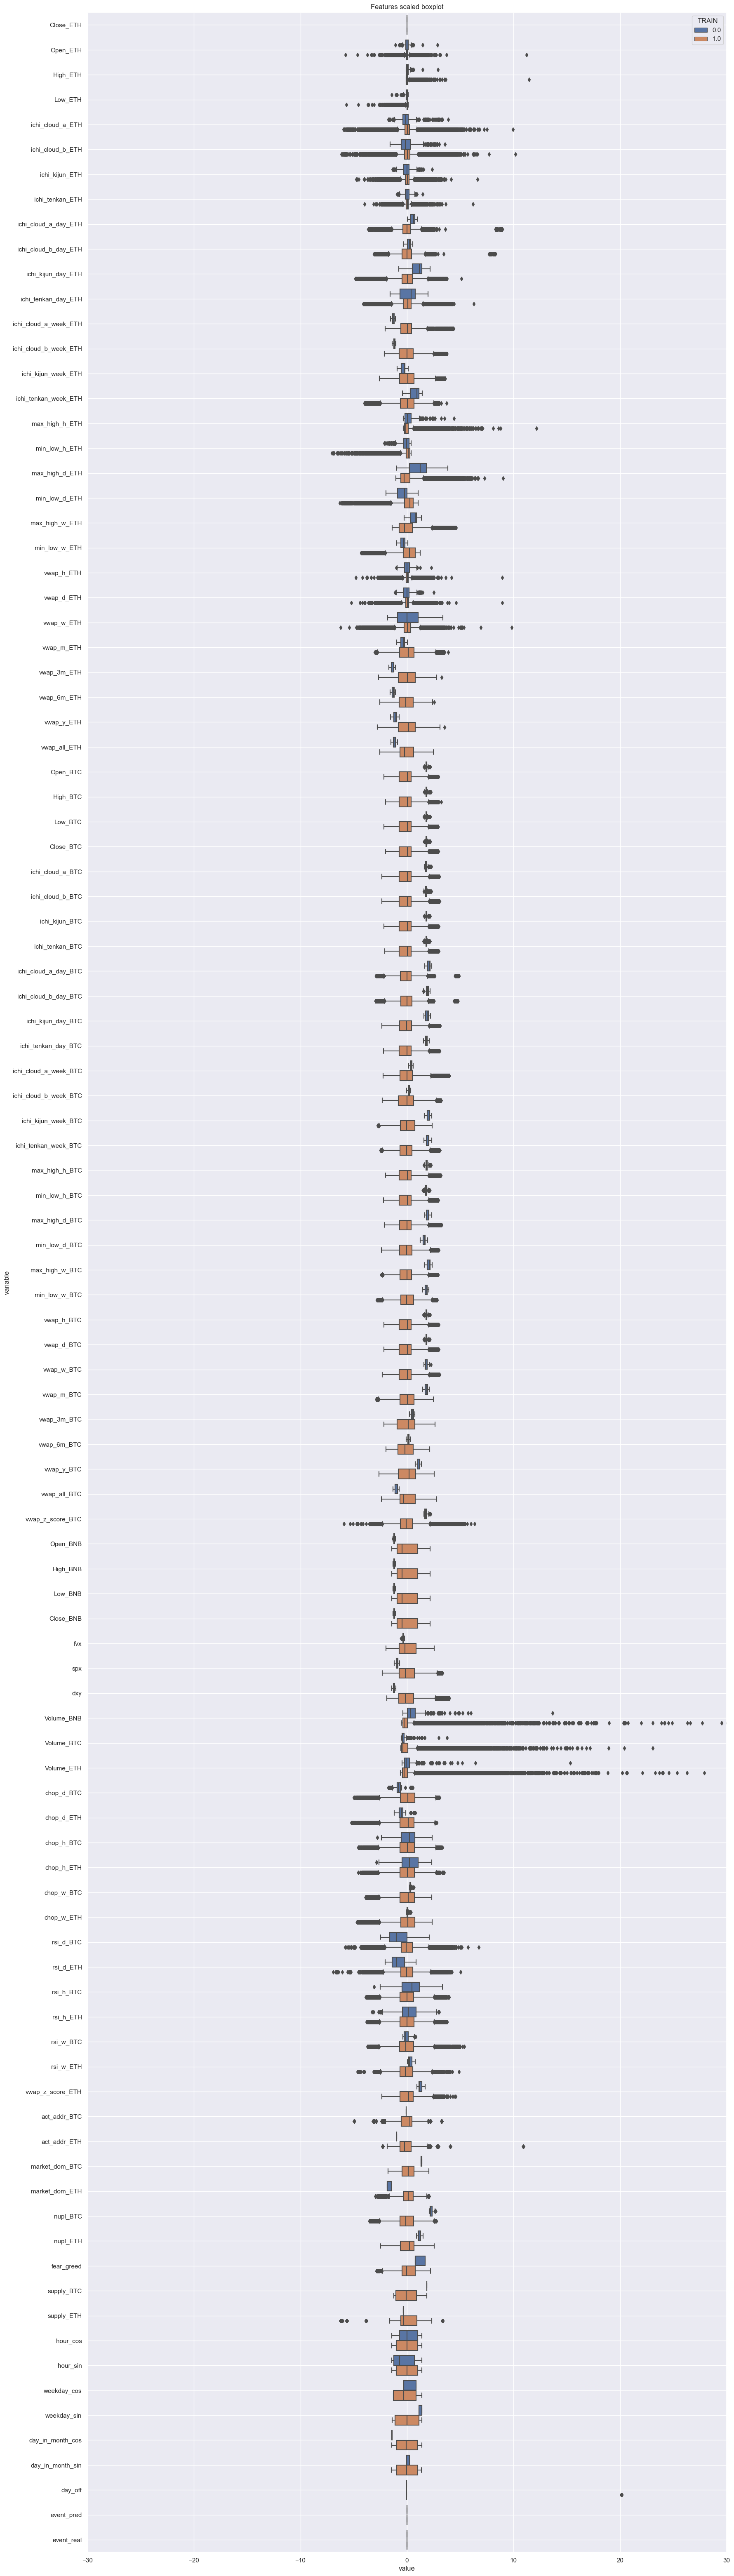

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<Axes: >

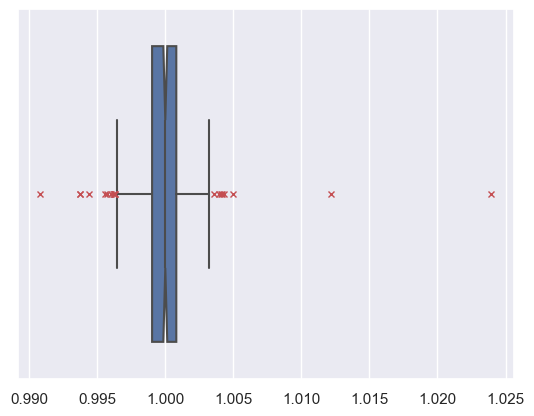

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


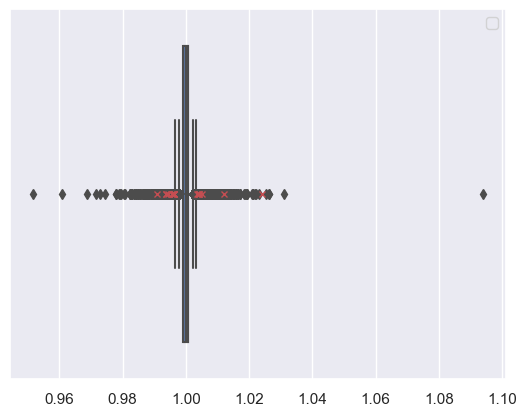

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

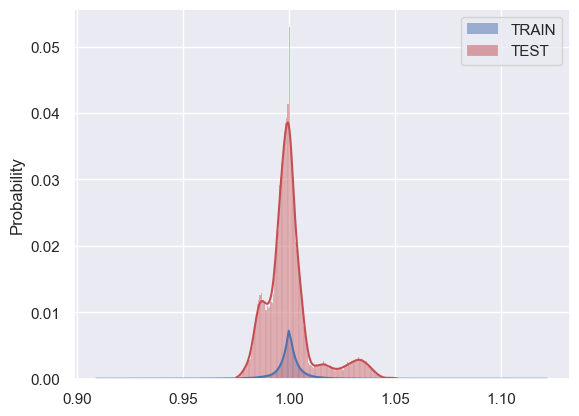

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(91325, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(91325, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.102339  ],
       [-0.03308275],
       [-0.20653774],
       ...,
       [ 0.36381269],
       [-0.06059602],
       [-0.15494579]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(91325, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

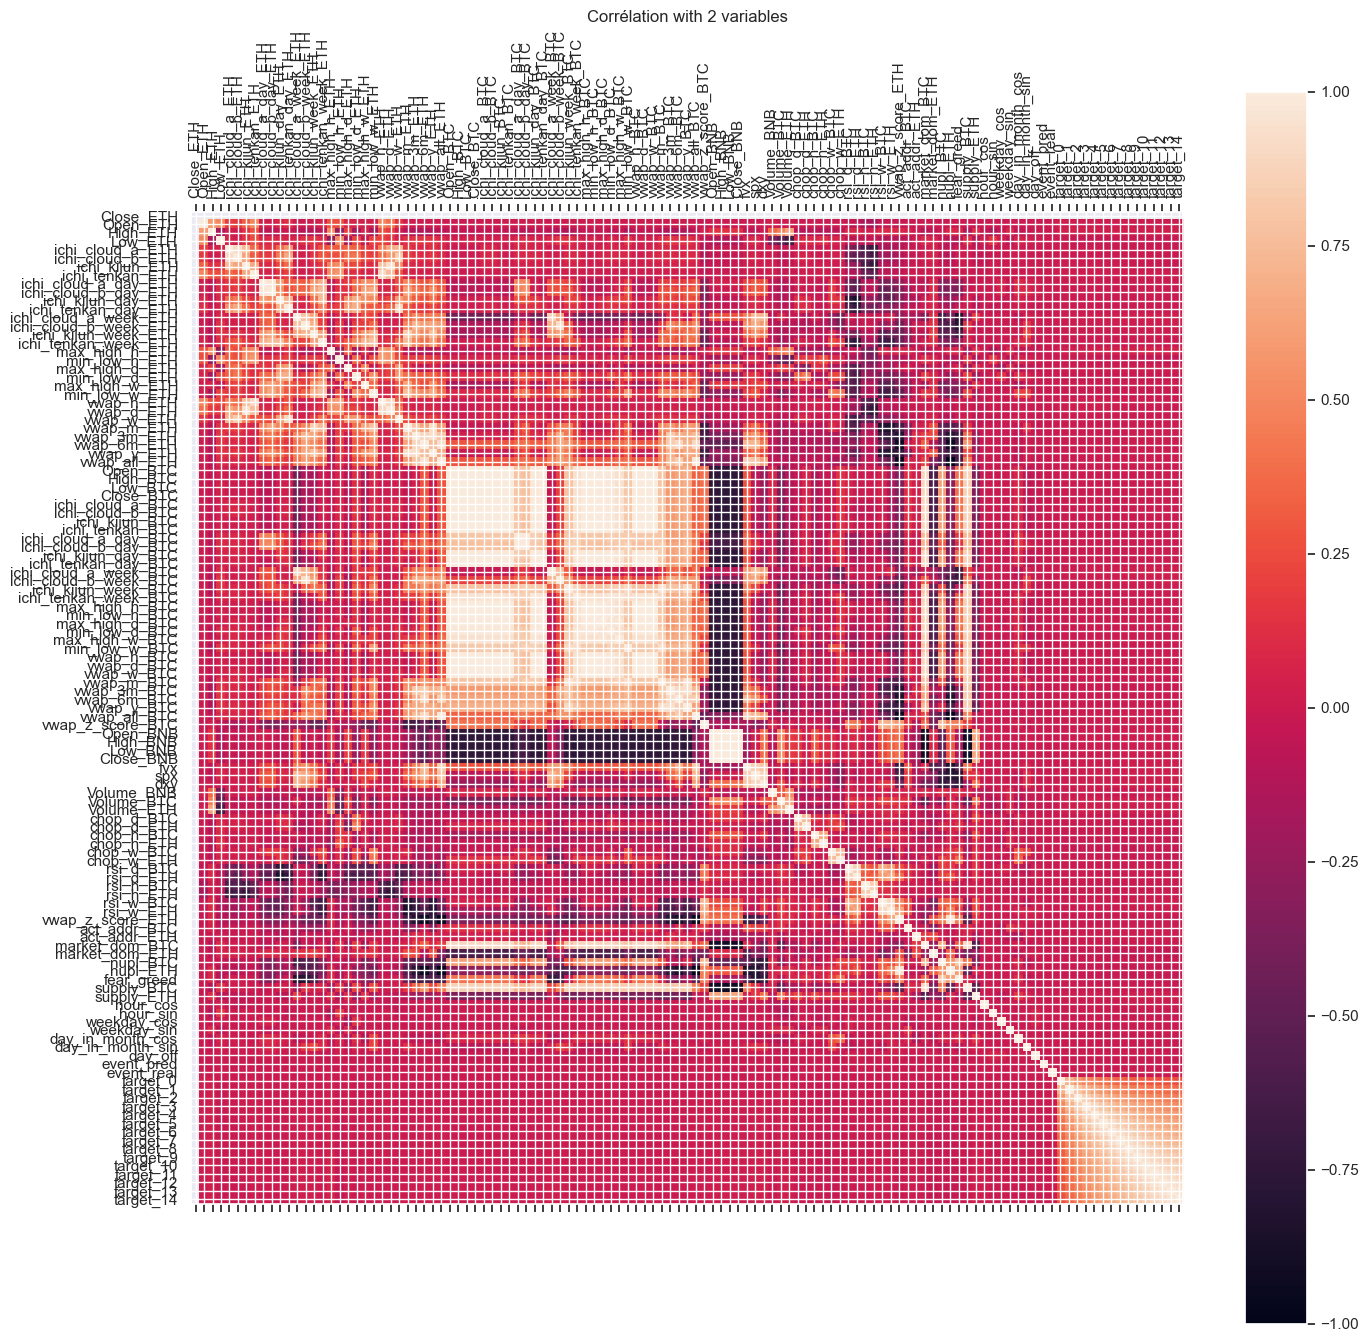

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


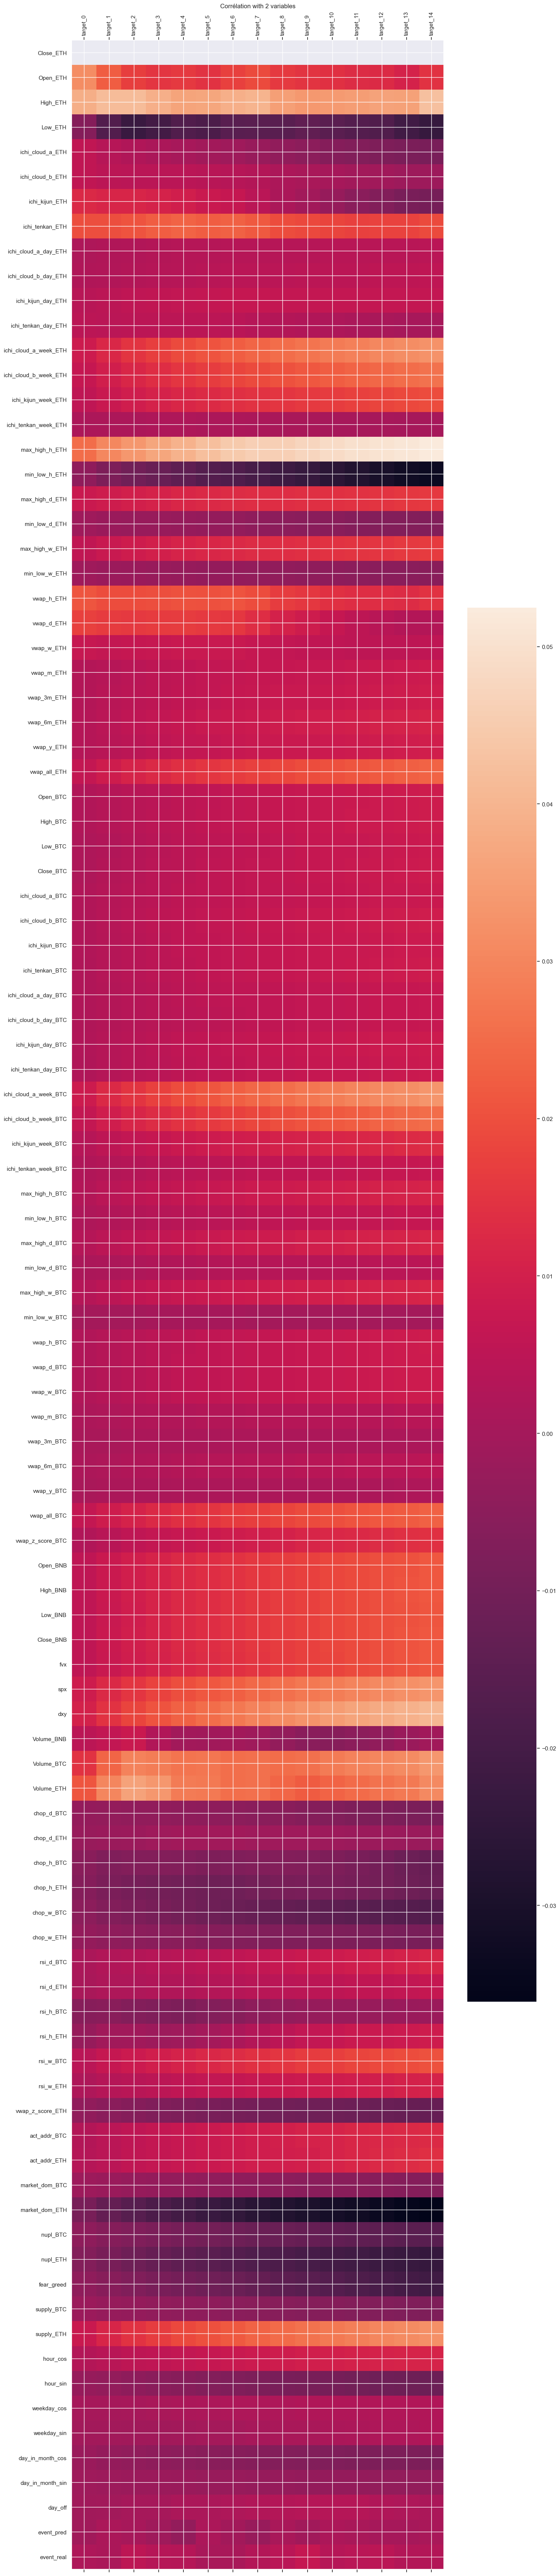

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


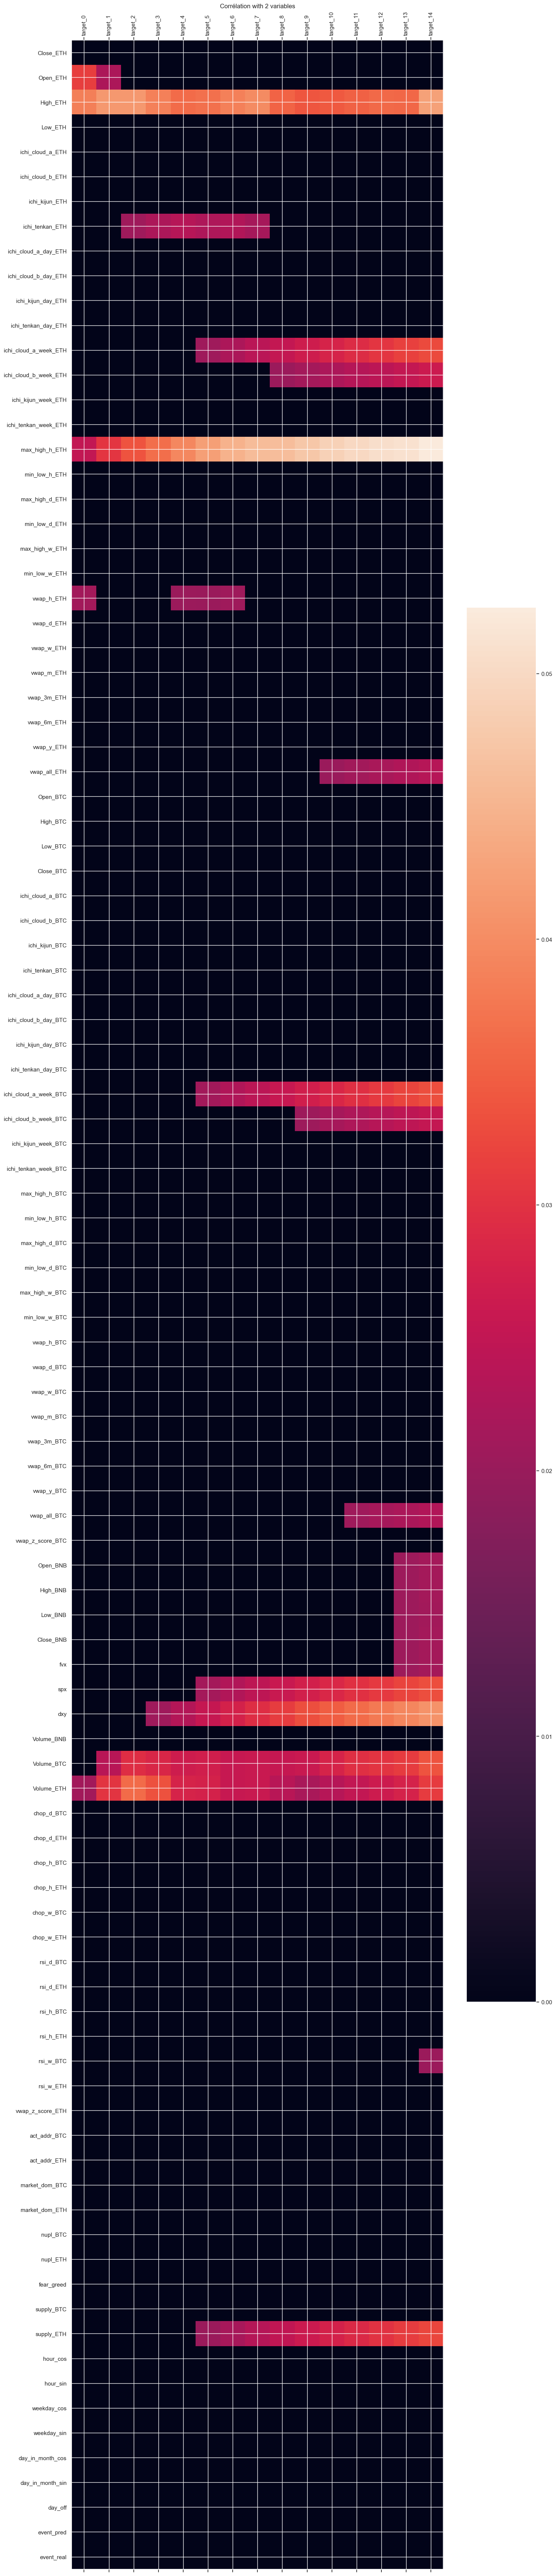

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

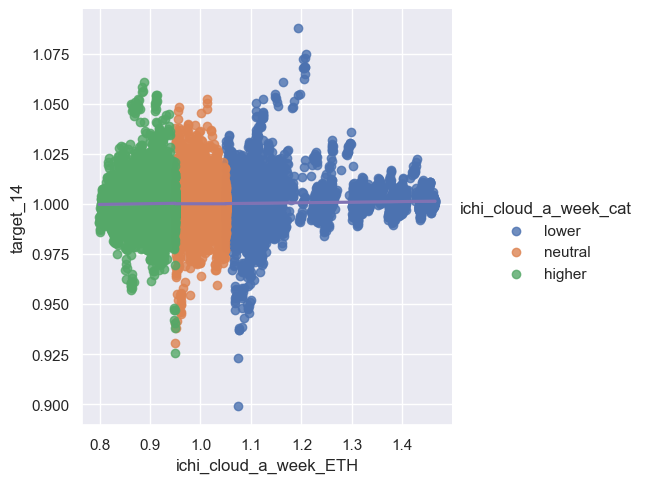

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

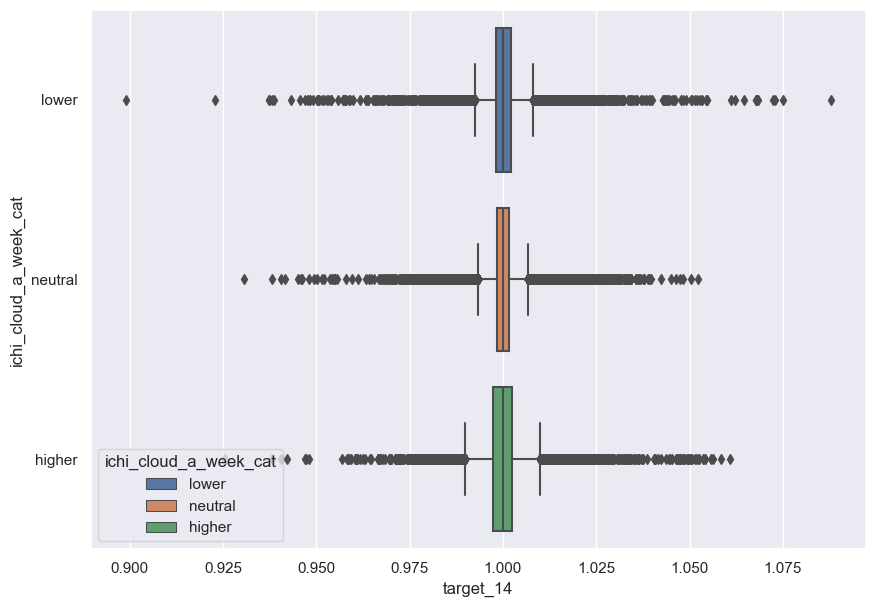

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


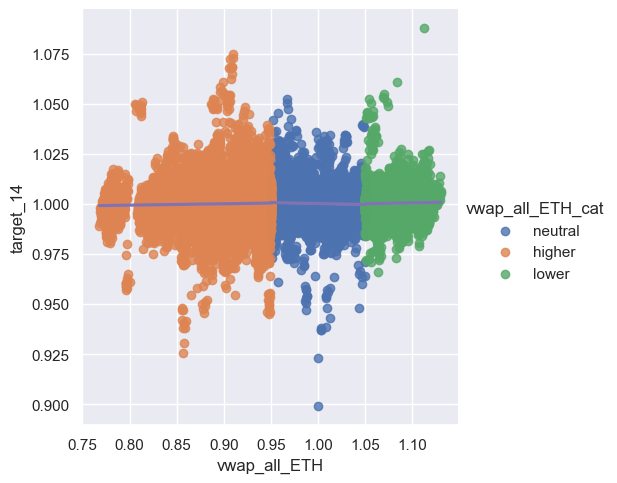

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

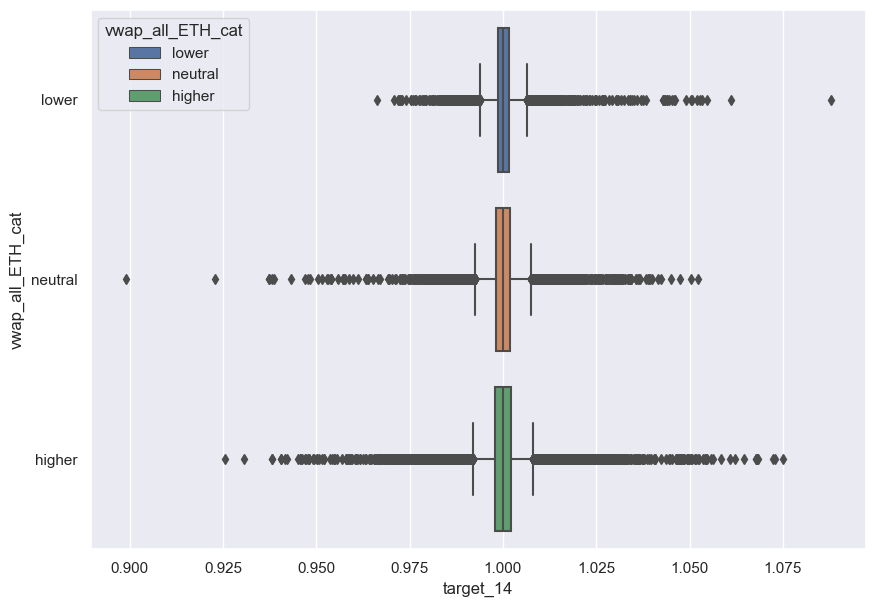

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

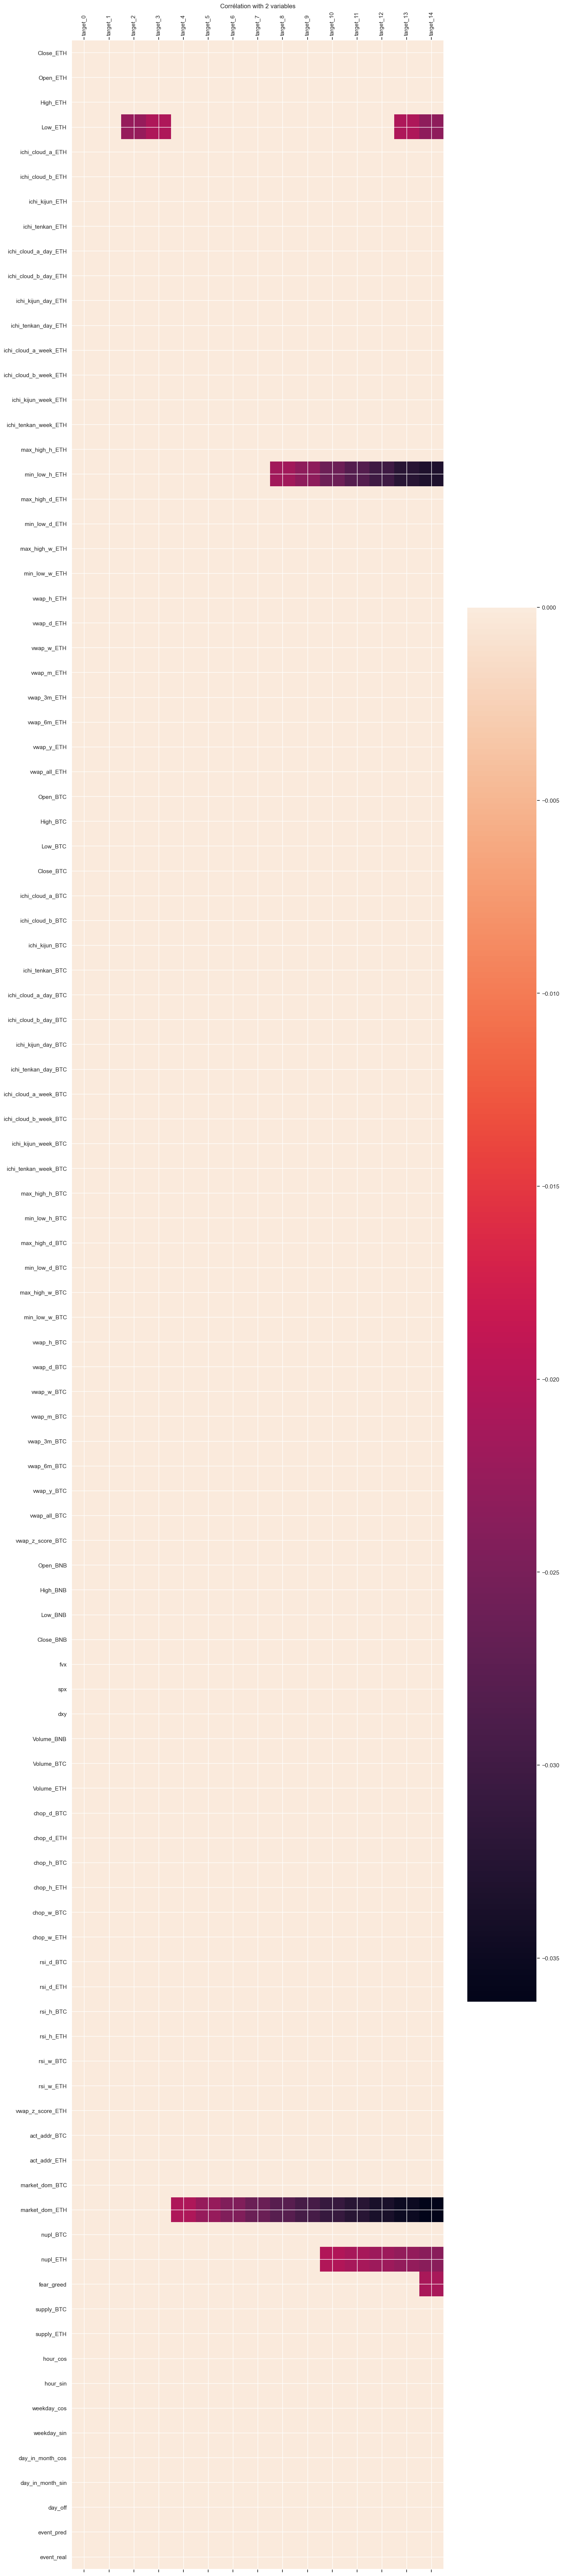

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

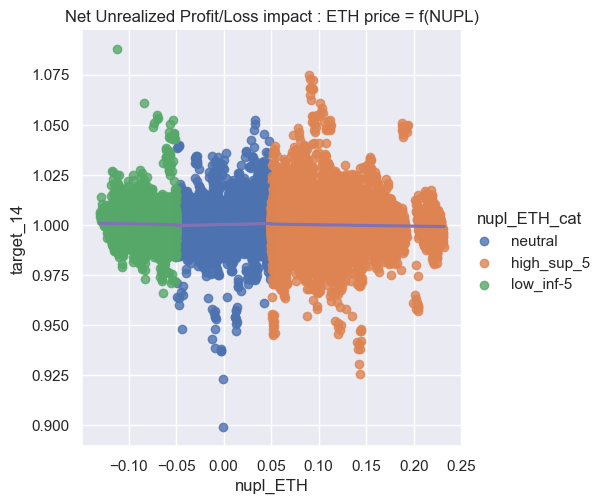

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

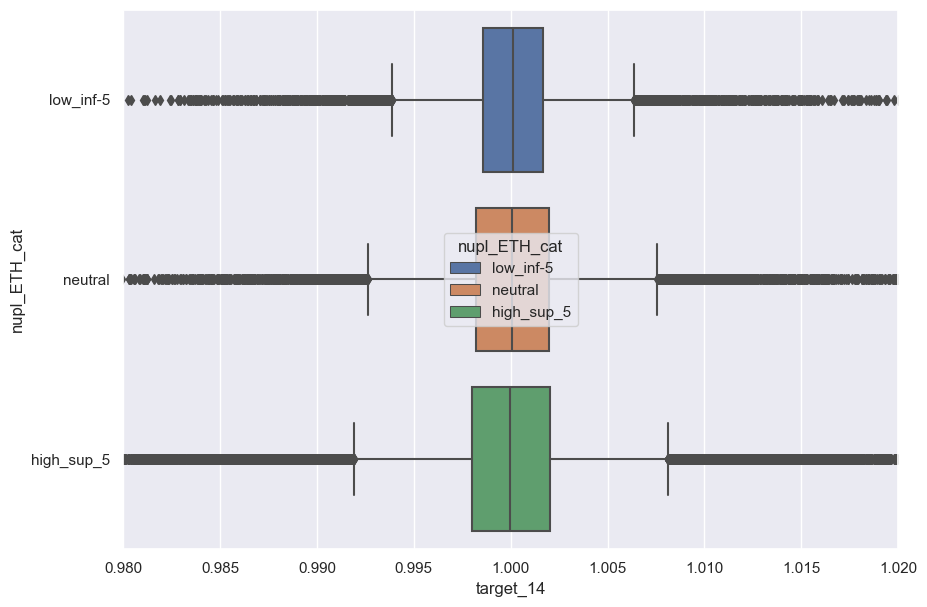

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    91325.000000
mean         1.000104
std          0.005392
min          0.899006
25%          0.998136
50%          1.000025
75%          1.001956
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    91325.000000
mean         1.000014
std          0.002007
min          0.907143
25%          0.999275
50%          1.000005
75%          1.000751
max          1.053076
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

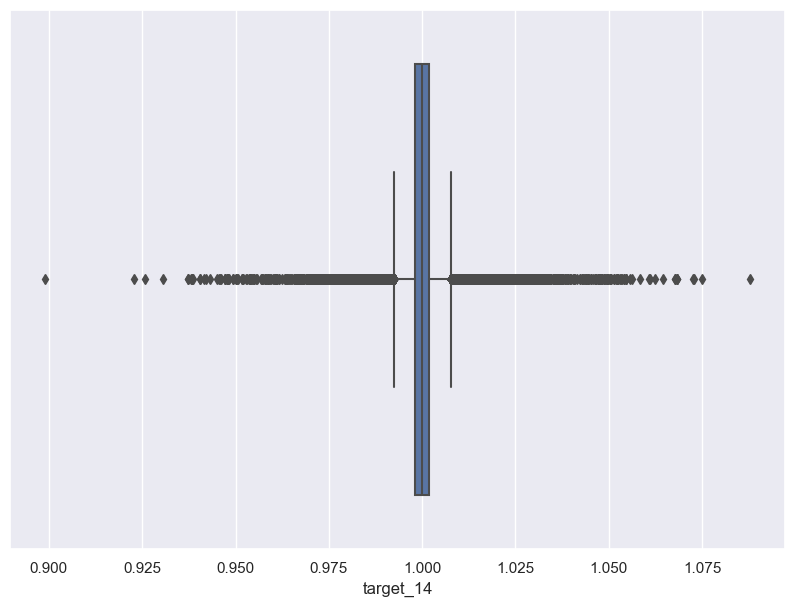

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00149483, 1.00131041, 1.00075227, ..., 0.99905845, 0.99792276,
        0.99684047],
       [0.99981585, 0.99925854, 0.99984492, ..., 0.99643326, 0.99535258,
        0.99511027],
       [0.99944259, 1.00002908, 0.99861376, ..., 0.99553591, 0.99529356,
        0.99473615]])

In [89]:
y_train_sca

array([[ 0.102339  ,  0.08329408, -0.10927118, ..., -0.04155592,
         0.02404323, -0.05002033],
       [-0.03308275, -0.22555939, -0.05634916, ..., -0.09230634,
        -0.16633581, -0.3165099 ],
       [-0.20653774, -0.03731476, -0.15788613, ..., -0.1473097 ,
        -0.29749509, -0.36941486],
       ...,
       [ 0.36381269,  0.31719369,  0.17610986, ..., -0.25204888,
        -0.5391238 , -0.81270374],
       [-0.06059602, -0.20146927, -0.05324611, ..., -0.91563536,
        -1.18880696, -1.25005619],
       [-0.15494579, -0.00669534, -0.36445676, ..., -1.14246534,
        -1.20372586, -1.34462505]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(91325, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
#epochs = 500 #100 #150 #6 #300
#patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in LIST_UNITS_AE: #[32, 64, 128]: #[104]: #
        for encoding_dim in LIST_UNITS_ENC_AE:#[16, 20, 32]:
            for dropout_autoenc in LIST_DROPOUT_AE: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = X_train.shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=PATIENCE_AE, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if PATIENCE_AE == 0:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1)
                    else:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                            epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 32)          1275936   
                                                                 
 model_1 (Functional)        (None, None, 102)         1168486   
                                                                 
Total params: 2444422 (9.32 MB)
Trainable params: 2444422 (9.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                    

In [95]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [96]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [97]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2854/2854 [==============================] - 72s 25ms/step


(91325, 72, 102)

### Results

In [98]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

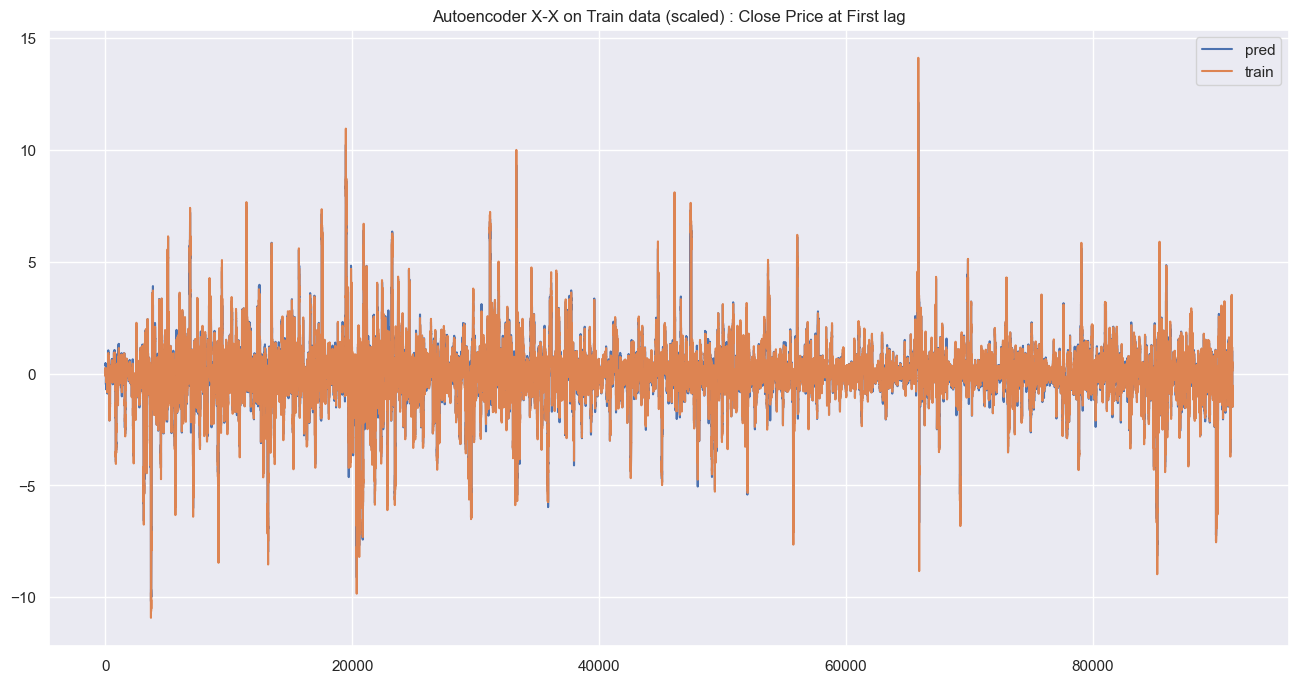

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [100]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(91325, 72, 102)
(91325, 72, 102)
(72, 102)
(1, 102)


In [101]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.087699  0.105021  0.067409  0.073675          0.104454   
lag_1    0.063385  0.062062  0.050594  0.058795          0.093006   
lag_2    0.054499  0.053584  0.045778  0.052900          0.090569   
lag_3    0.055133  0.050834  0.047323  0.053644          0.089782   
lag_4    0.051397  0.048118  0.044642  0.051110          0.087248   
...           ...       ...       ...       ...               ...   
lag_67   0.037181  0.034449  0.031629  0.038982          0.044809   
lag_68   0.036917  0.034295  0.031439  0.038818          0.044732   
lag_69   0.036644  0.034136  0.031249  0.038647          0.044661   
lag_70   0.036406  0.033941  0.031043  0.038467          0.044595   
lag_71   0.036105  0.033870  0.030799  0.038266          0.044527   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.085861        0.099173         0.085401   
lag_1           0.070143        0.087641         0.075012   
lag_2           0.064470        0.082876         0.070225   
lag_3           0.062233        0.080851         0.067993   
lag_4           0.059191        0.076883         0.062375   
...                  ...             ...              ...   
lag_67          0.037237        0.042745         0.041717   
lag_68          0.037186        0.042646         0.041618   
lag_69          0.037137        0.042544         0.041508   
lag_70          0.037089        0.042449         0.041392   
lag_71          0.037016        0.042348         0.041266   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.099975              0.094794  ...    0.101007  0.076857   
lag_1               0.072551              0.071283  ...    0.055553  0.047022   
lag_2               0.063226              0.061221  ...    0.042257  0.042586   
lag_3               0.057555              0.054988  ...    0.034915  0.043985   
lag_4               0.053292              0.050896  ...    0.030627  0.045732   
...                      ...                   ...  ...         ...       ...   
lag_67              0.037750              0.035407  ...    0.020937  0.039101   
lag_68              0.037746              0.035428  ...    0.020940  0.039091   
lag_69              0.037742              0.035451  ...    0.020945  0.039085   
lag_70              0.037742              0.035474  ...    0.020944  0.039079   
lag_71              0.037753              0.035494  ...    0.020946  0.039074   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.070667     0.079328     0.071227          0.100661   
lag_1   0.043856     0.045963     0.043370          0.061993   
lag_2   0.041104     0.038518     0.037562          0.050255   
lag_3   0.046758     0.036213     0.040269          0.046539   
lag_4   0.048452     0.032857     0.038898          0.043498   
...          ...          ...          ...               ...   
lag_67  0.041207     0.031892     0.038570          0.039593   
lag_68  0.041208     0.031865     0.038572          0.039588   
lag_69  0.041208     0.031832     0.038562          0.039589   
lag_70  0.041205     0.031802     0.038563          0.039594   
lag_71  0.041186     0.031771     0.038559          0.039593   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.095778  0.067598    0.113843    0.119658  
lag_1           0.059050  0.033656    0.052984    0.056541  
lag_2           0.048189  0.022088    0.039468    0.038535  
lag_3           0.042894  0.017040    0.028319    0.026575  
lag_4           0.039995  0.014331    0.024191    0.022885  
...                  ...       ...         ...         ...  
lag_67          0.036049  0.010243    0.021062    0.018060  
lag_68          0.036056  0.010227    0.021067    0.018041  
lag_69          0.036062  0.010215    0.021071    0.018041  
lag_70          0.036068  0.010207    0.021072    0.018033  
lag_71          0.036076  0.01019

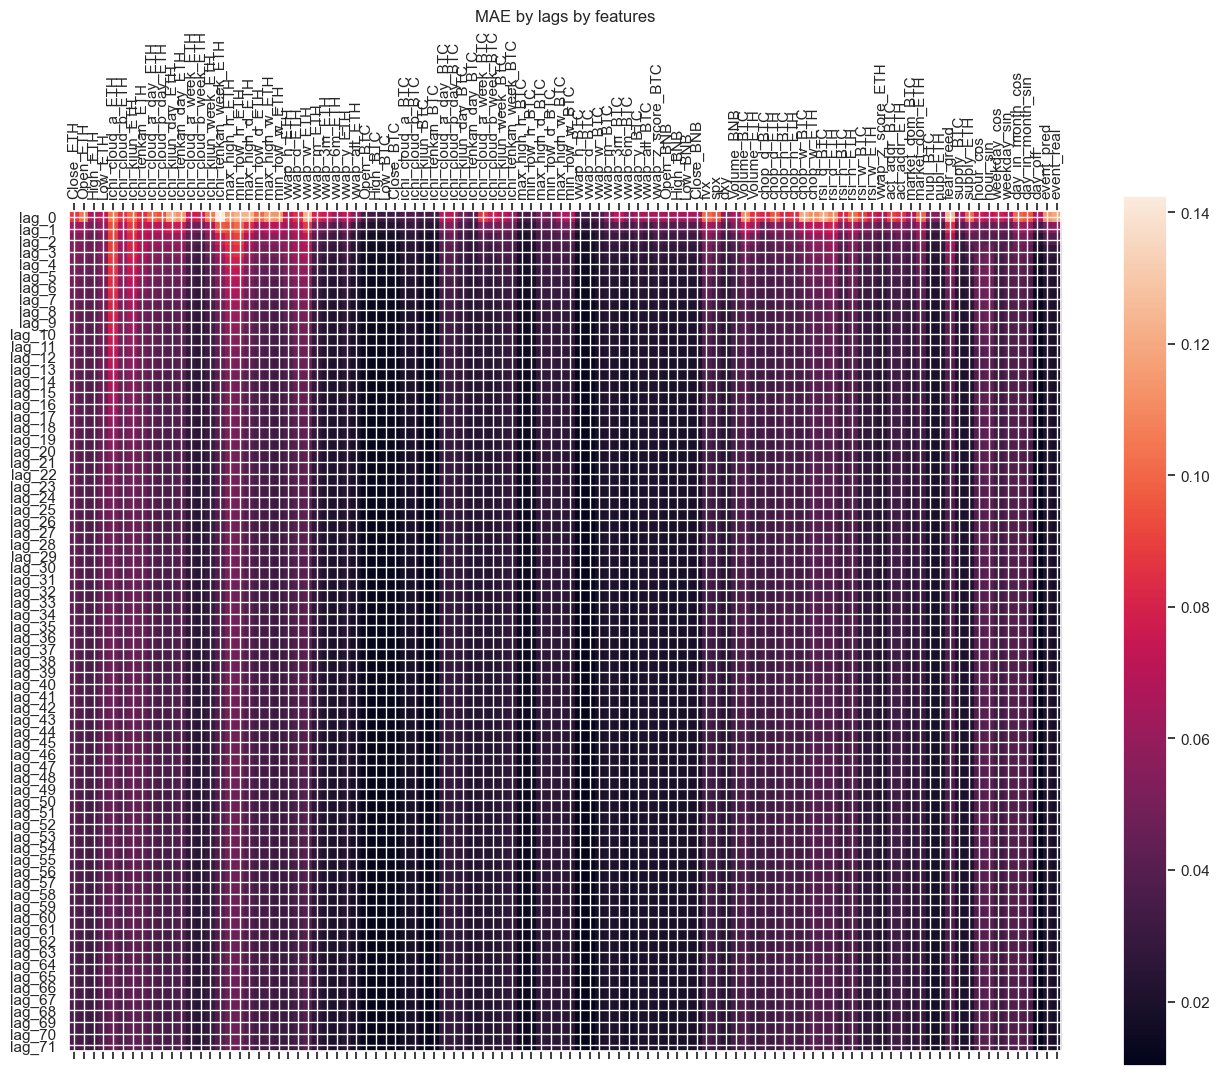

In [102]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

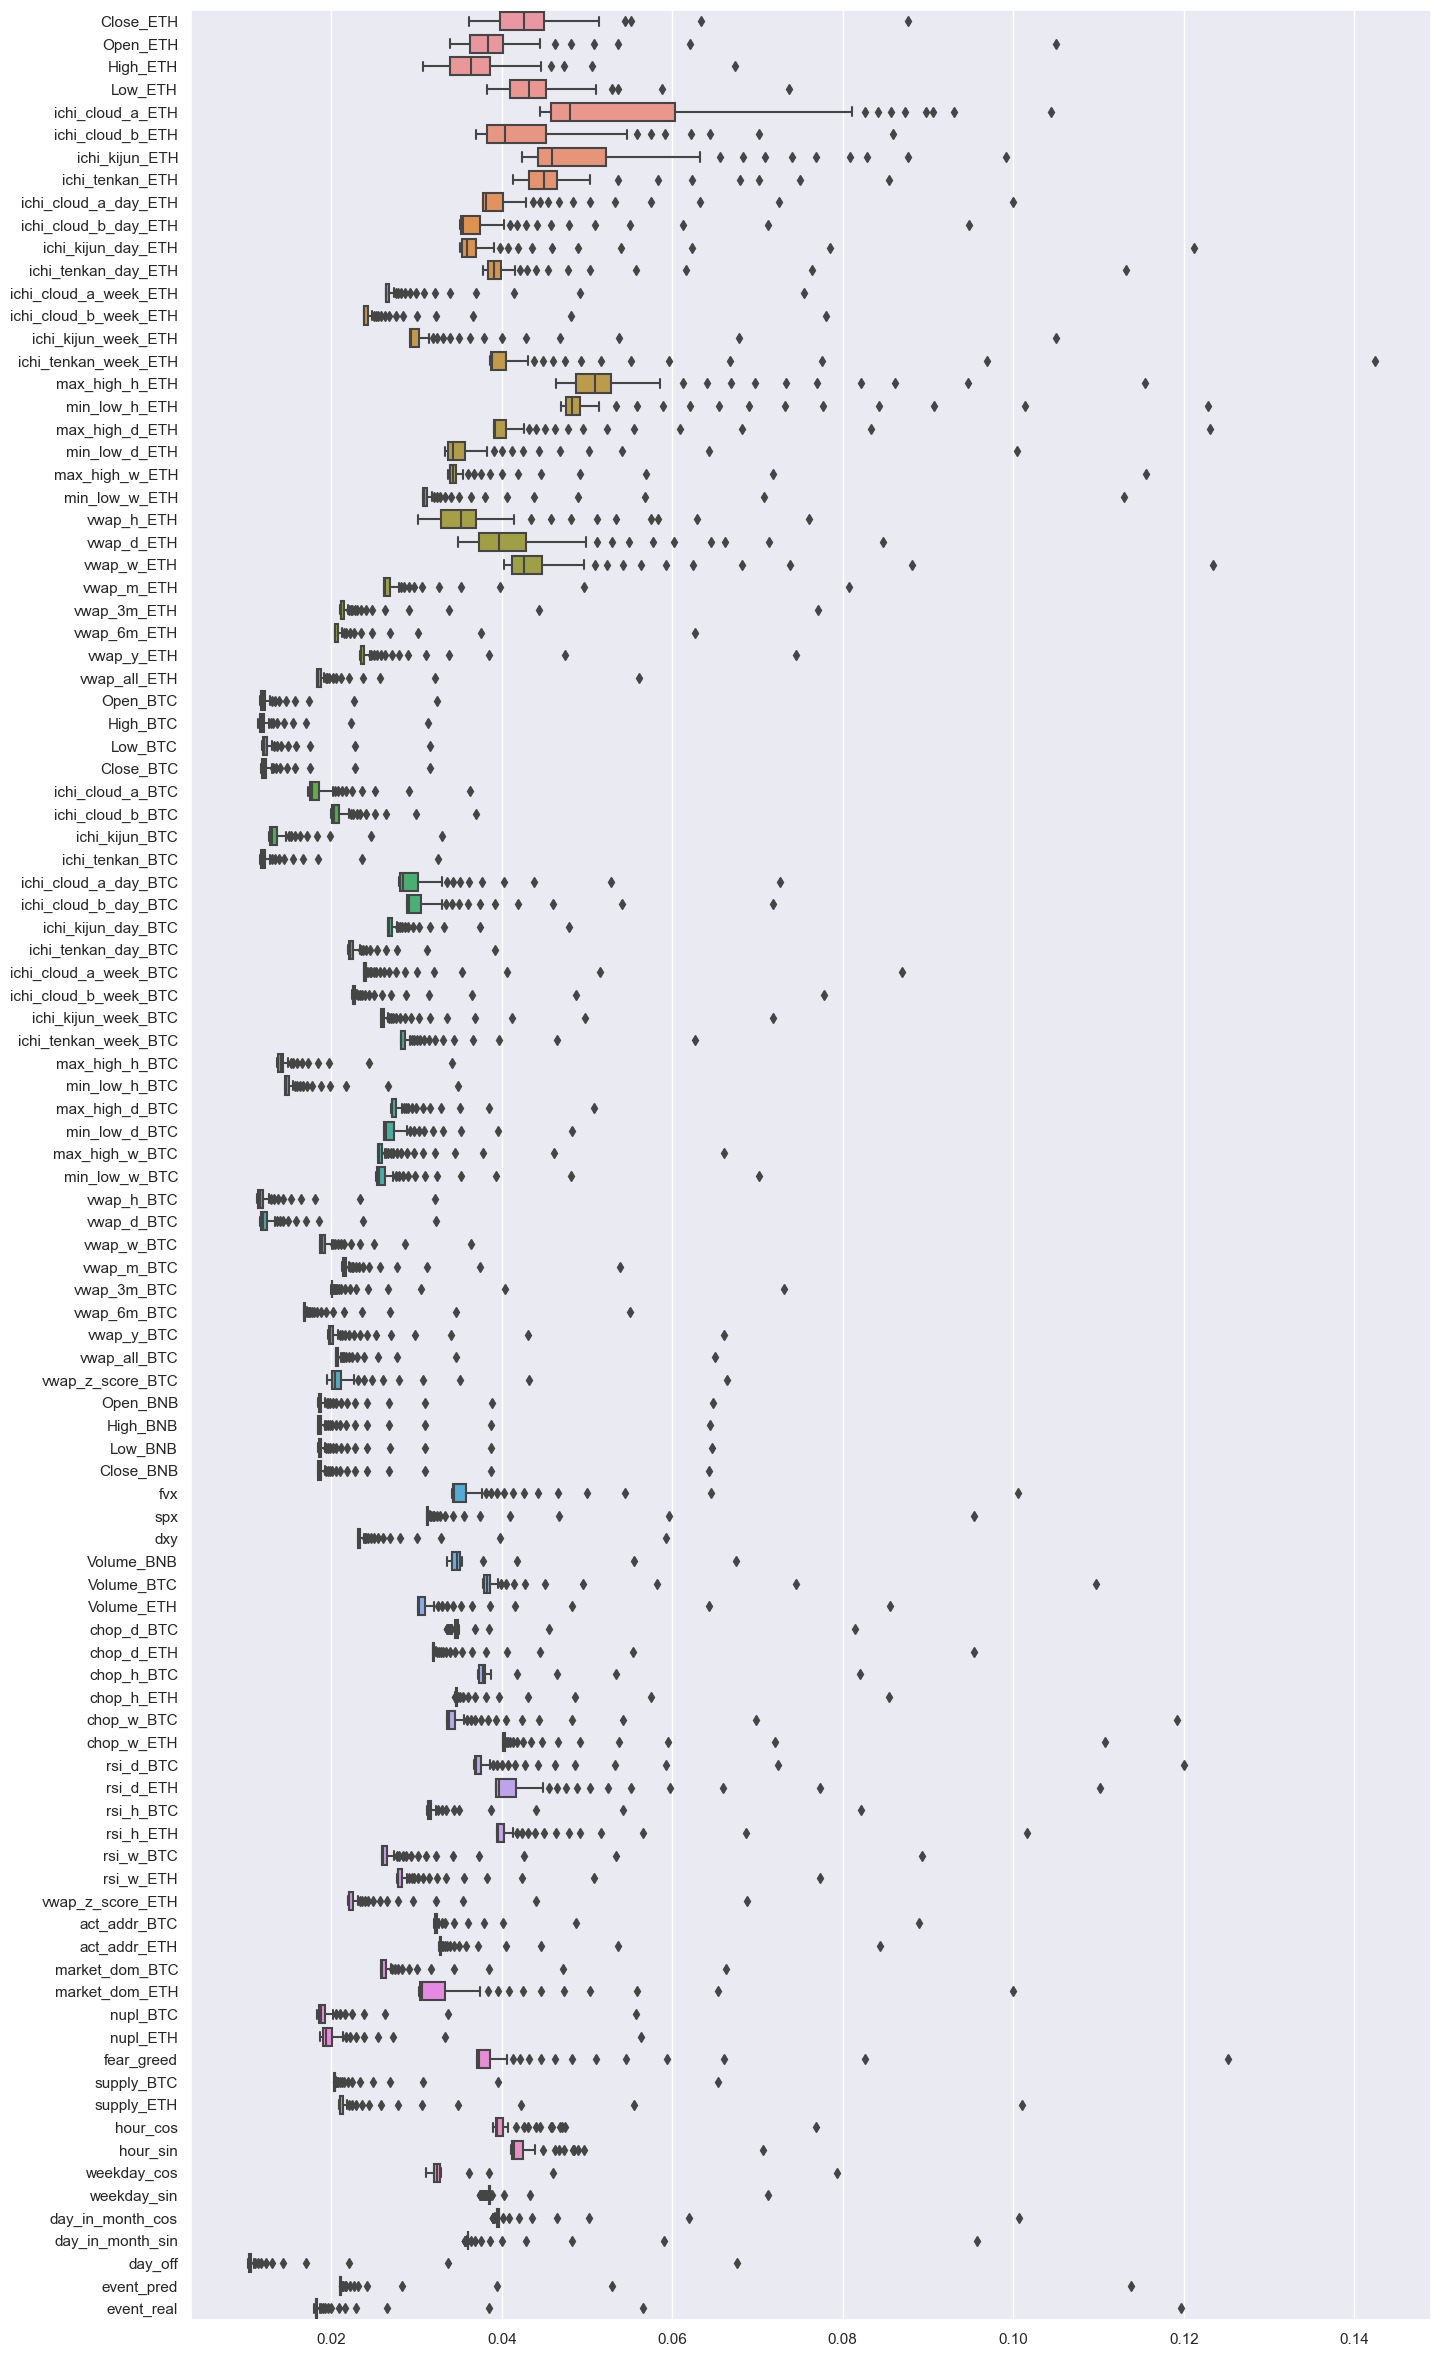

In [103]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [104]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.043571   0.03992  0.037076  0.043963          0.055763   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.043627        0.050873         0.046754              0.041349   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.038683  ...    0.023605  0.040781  0.042768     0.033296   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.038979          0.041015          0.037518  0.011979    0.023313   

   event_real  
0    0.020795  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

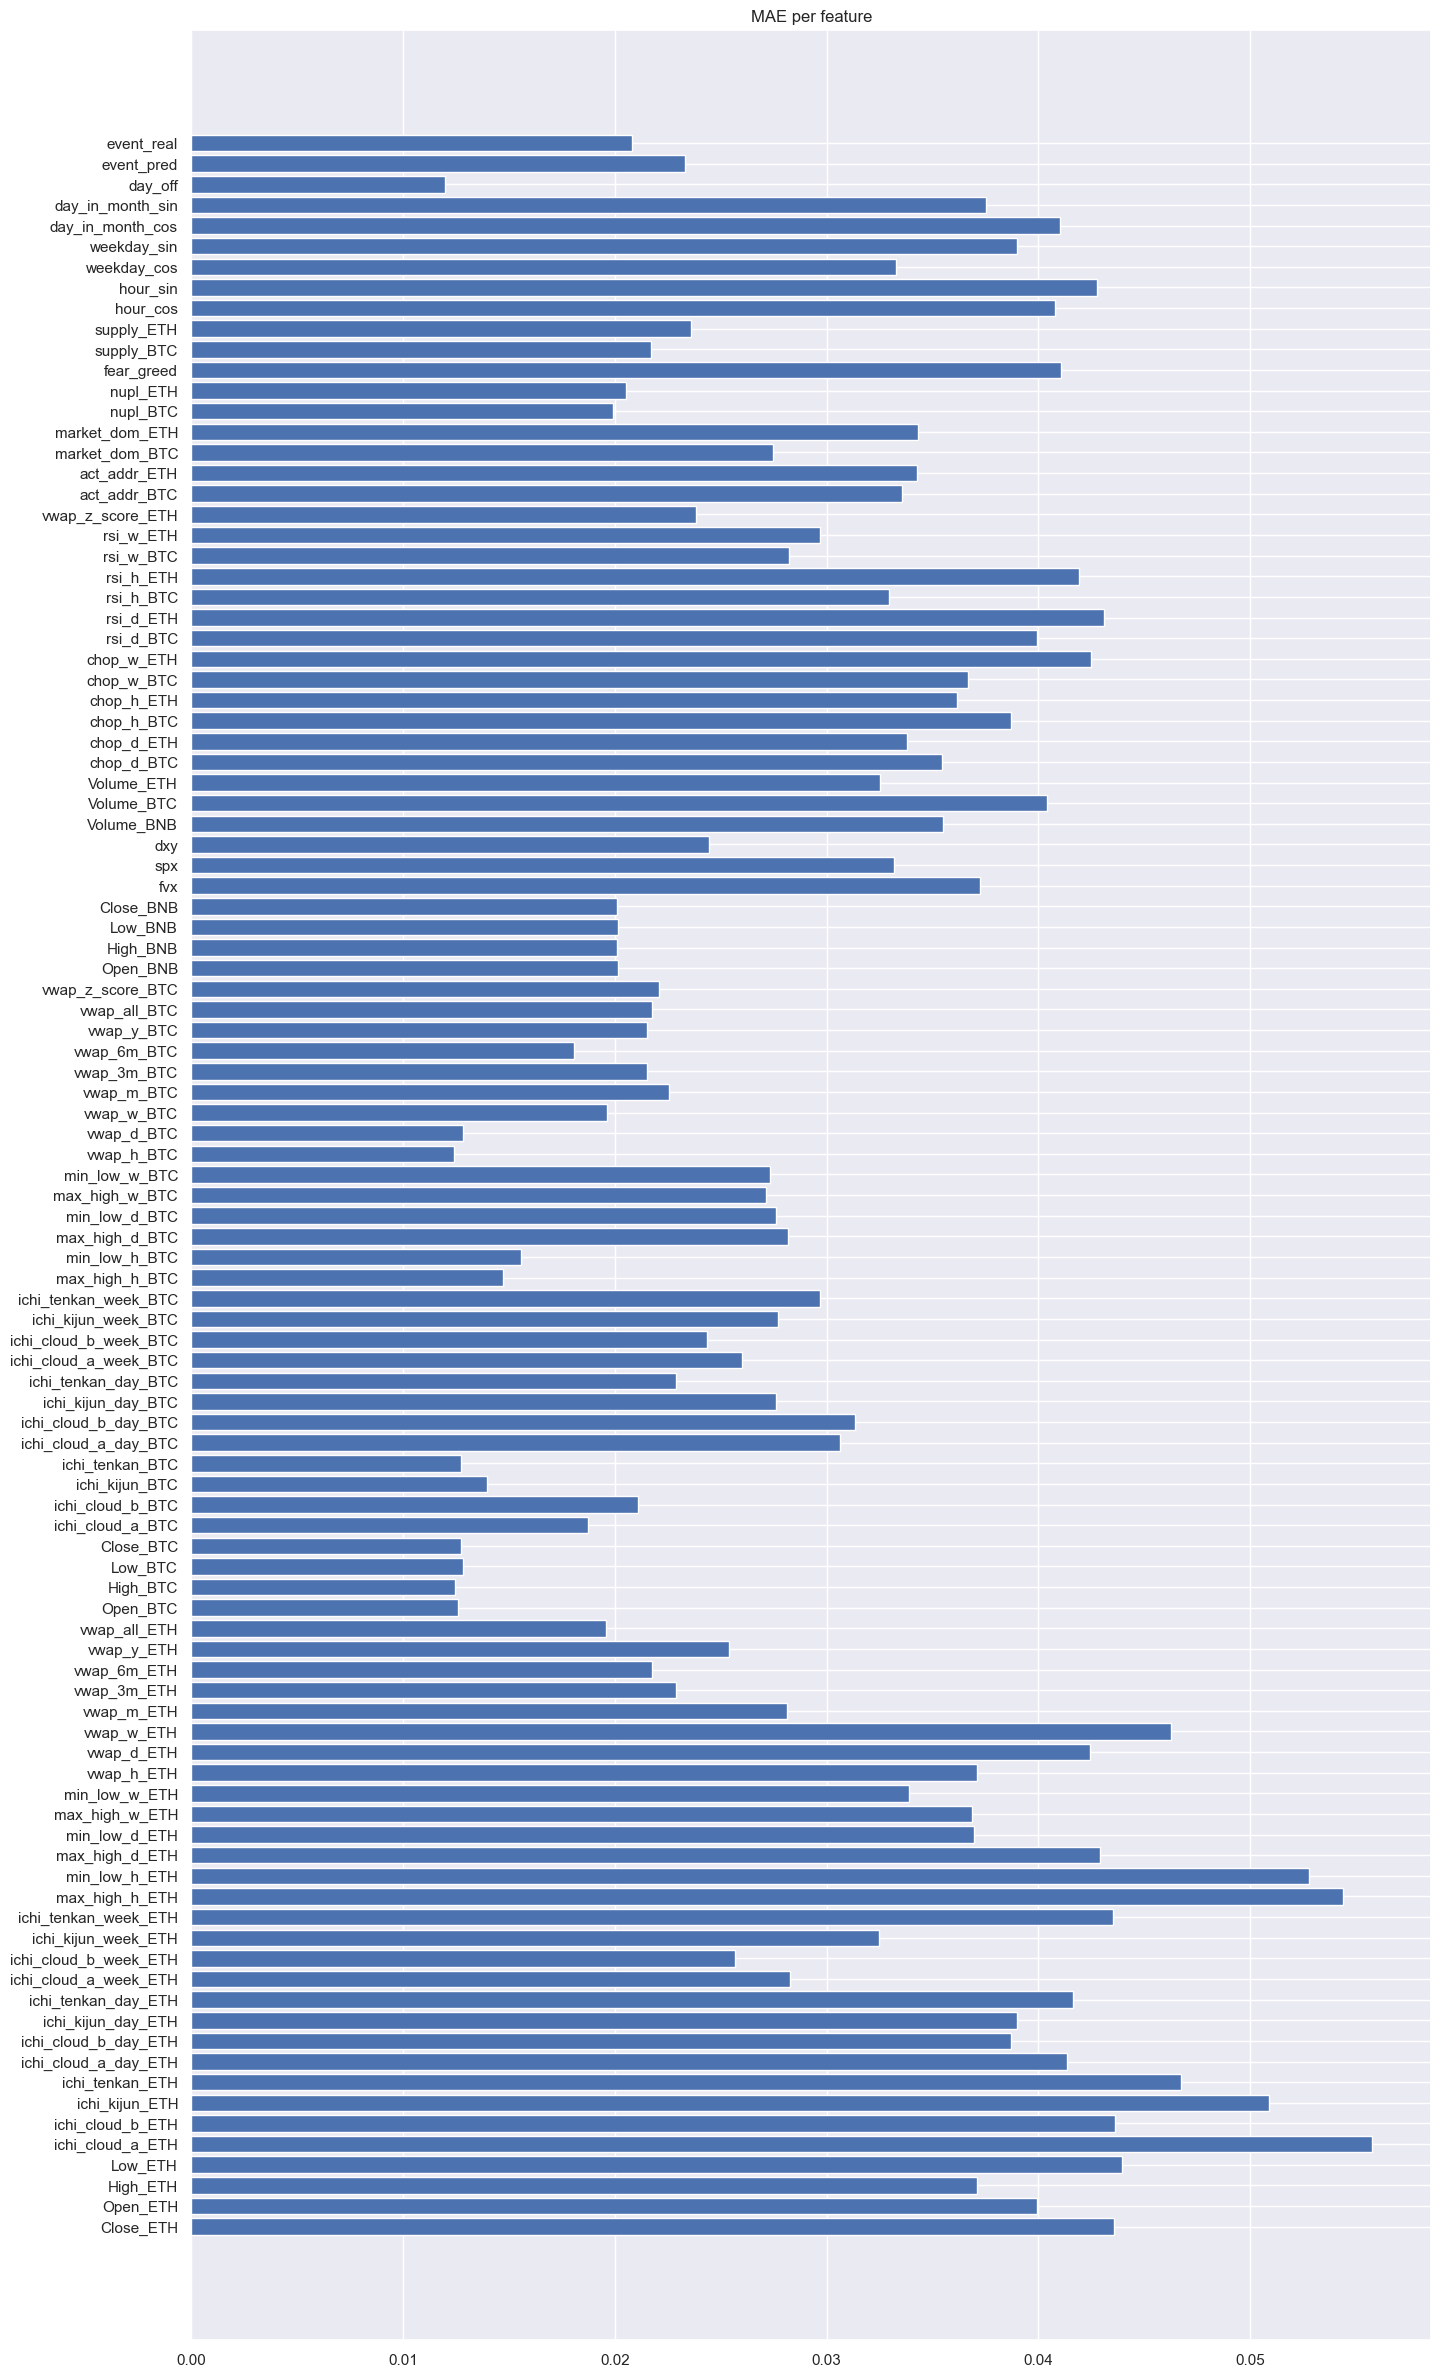

In [105]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [106]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(91325,)
(91325,)
[1196.32 1195.38 1194.55 ... 2049.5  2048.69 2046.98]
[1196.32 1195.38 1194.55]


In [107]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.99996495, 1.0001922 , 1.0001876 , ..., 0.99997544, 1.0001823 ,
       1.0005368 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 2049.5  2048.69 2046.98]
[1198.78011028 1199.20028166 1199.20228302 ... 2048.16288065 2048.83758364
 2046.96309991]


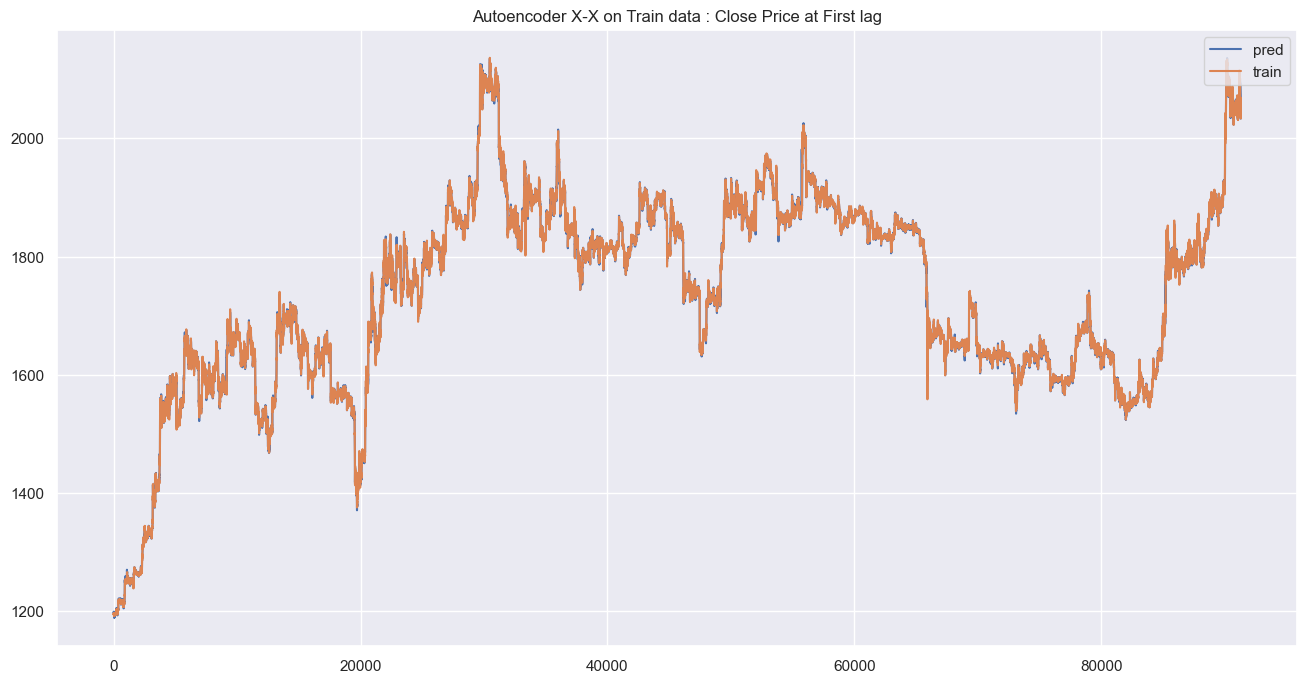

In [108]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [109]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

12/12 [==============================] - 3s 69ms/step


(371, 72, 102)

In [110]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-11-14 09:35:00'

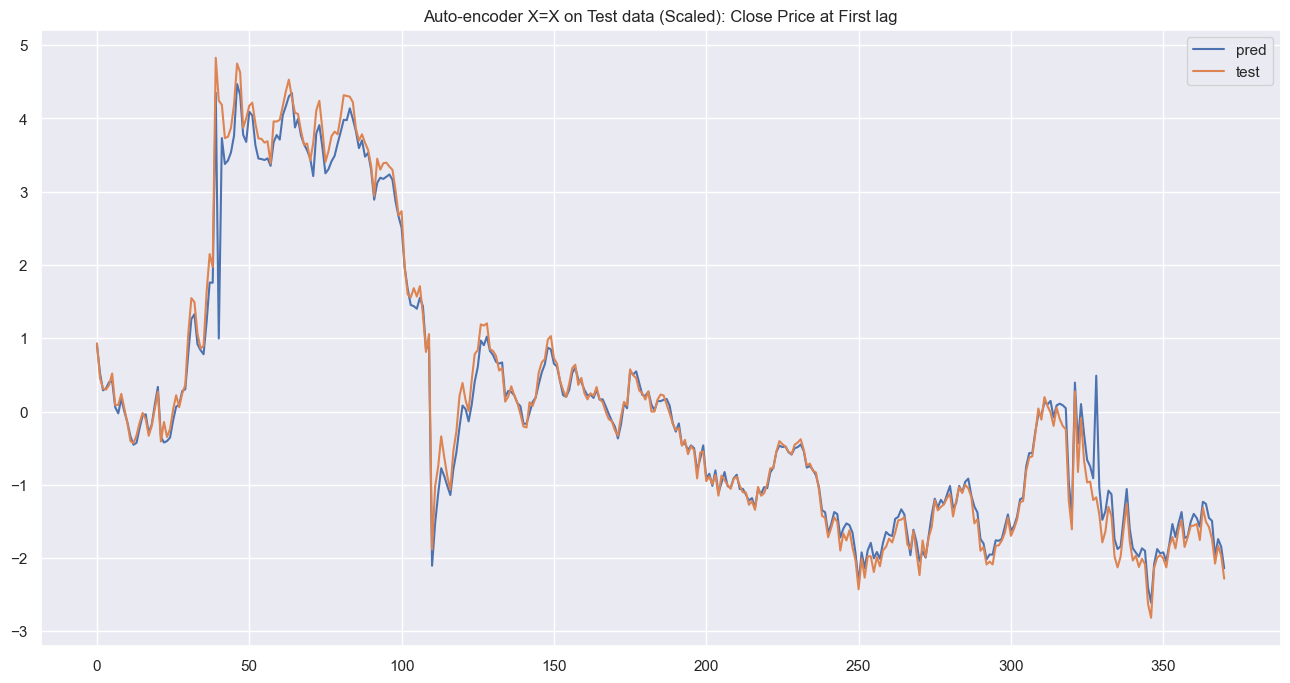

In [111]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [112]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [2052.36 2048.77 2049.3  2047.44 2043.82 2047.87 2045.84 2049.38 2049.86]
X test pred :  [2052.0796866  2049.87491275 2048.89565562 2047.74736983 2044.49246244
 2046.09494396 2045.33887094 2047.41682786 2048.78531263]


[2052.36 2048.77 2049.3  2047.44 2043.82 2047.87 2045.84 2049.38 2049.86
 2049.03 2047.7  2044.57 2042.34 2045.51 2045.91 2046.58 2043.3  2040.74
 2039.85 2038.55 2036.64 2033.94 2037.82 2035.23 2035.83 2036.7  2038.17
 2031.84 2027.68 2029.51 2032.86 2034.24 2034.65 2034.15 2029.16 2029.68
 2031.88 2031.73 2032.86 2031.48 2034.81 2037.03 2036.86 2035.08 2033.57
 2034.19 2048.08 2048.42 2043.66 2048.53 2044.84 2043.1  2043.03 2046.04
 2048.02 2049.44 2053.45 2047.02 2050.69 2048.8  2049.26 2048.09 2049.54
 2050.51 2045.   2045.   2042.01 2038.38 2031.74 2030.94 2025.63 2037.04
 2041.38 2044.37 2042.74 2038.09 2039.48 2044.71 2048.21 2046.15 2048.68
 2050.76 2051.78 2050.   2051.38 2048.89 2047.27 2045.37 2046.71 2043.51
 2038.25 2032.46 2041.21 2040.59 2041.46 2040.22 2036.59 2034.79 2031.21
 2023.95 2023.8  2015.4  2008.88 2010.18 2016.77 2015.14 2015.12 2005.19
 1996.6  2000.59 1953.81 1966.17 1969.19 1976.21 1974.21 1970.8  1966.4
 1971.   1973.21 1980.59 1983.22 1976.95 1974.61 197

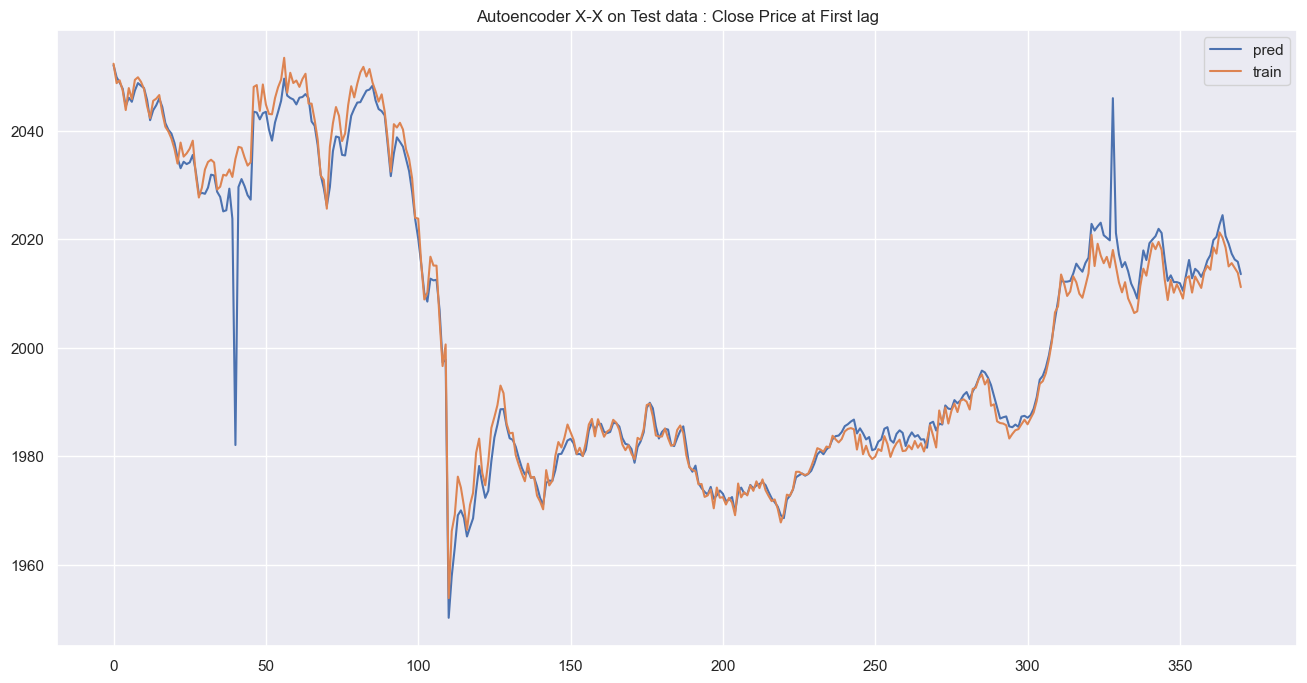

In [113]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [114]:
X_test_sca.shape

(371, 72, 102)

In [115]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.20695203873999587

In [116]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(371, 72, 102)
(371, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.087699  0.105021  0.067409  0.073675          0.104454   
lag_1    0.063385  0.062062  0.050594  0.058795          0.093006   
lag_2    0.054499  0.053584  0.045778  0.052900          0.090569   
lag_3    0.055133  0.050834  0.047323  0.053644          0.089782   
lag_4    0.051397  0.048118  0.044642  0.051110          0.087248   
...           ...       ...       ...       ...               ...   
lag_67   0.068674  0.060423  0.068797  0.064970          0.073964   
lag_68   0.067635  0.060164  0.068847  0.064393          0.073711   
lag_69   0.067717  0.060348  0.068129  0.063965          0.073059   
lag_70   0.067150  0.059224  0.068114  0.065004          0.072377   
lag_71   0.066629  0.059961  0.068382  0.064413          0.072420   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.085861        0.099173         0.085401   
lag_1           0.070143        0.087641         0.075012   
lag_2           0.064470        0.082876         0.070225   
lag_3           0.062233        0.080851         0.067993   
lag_4           0.059191        0.076883         0.062375   
...                  ...             ...              ...   
lag_67          0.072188        0.066372         0.059958   
lag_68          0.072738        0.066444         0.059460   
lag_69          0.073172        0.066405         0.059056   
lag_70          0.073639        0.066958         0.059097   
lag_71          0.074080        0.066993         0.059587   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.099975              0.094794  ...  0.076857  0.070667   
lag_1               0.072551              0.071283  ...  0.047022  0.043856   
lag_2               0.063226              0.061221  ...  0.042586  0.041104   
lag_3               0.057555              0.054988  ...  0.043985  0.046758   
lag_4               0.053292              0.050896  ...  0.045732  0.048452   
...                      ...                   ...  ...       ...       ...   
lag_67              0.098901              0.174002  ...  0.103421  0.049693   
lag_68              0.099427              0.175111  ...  0.103795  0.049637   
lag_69              0.099710              0.175966  ...  0.104209  0.049932   
lag_70              0.100379              0.176948  ...  0.104555  0.049859   
lag_71              0.100525              0.177758  ...  0.104734  0.050123   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.079328     0.071227          0.100661          0.095778   
lag_1      0.045963     0.043370          0.061993          0.059050   
lag_2      0.038518     0.037562          0.050255          0.048189   
lag_3      0.036213     0.040269          0.046539          0.042894   
lag_4      0.032857     0.038898          0.043498          0.039995   
...             ...          ...               ...               ...   
lag_67     0.045073     0.065990          0.276237          0.233492   
lag_68     0.044960     0.065966          0.277113          0.234836   
lag_69     0.044879     0.065890          0.278431          0.235996   
lag_70     0.044961     0.065625          0.280252          0.237235   
lag_71     0.044719     0.065617          0.280582          0.238367   

         day_off  event_pred  event_real  dataset  
lag_0   0.067598    0.113843    0.119658    TRAIN  
lag_1   0.033656    0.052984    0.056541    TRAIN  
lag_2   0.022088    0.039468    0.038535    TRAIN  
lag_3   0.017040    0.028319    0.026575    TRAIN  
lag_4   0.014331    0.024191    0.022885    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.019488    0.055349    0.045351     TEST  
lag_68  0.019342    0.055346    0.045333     TEST  
lag_69  0.019436    0.055698    0.045490     TEST  
lag_70  0.019281    0.056011    0.045457     TEST  
lag_71  0.019164    0.056487    0.045565     TEST  

[144 ro

In [117]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0    0.08486  0.076411  0.083557  0.079232          0.090011   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.076254        0.076011         0.074822              0.110128   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.146946  ...     0.06292  0.105091  0.050822     0.058442   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.067909          0.250456          0.222004  0.023263    0.052236   

   event_real  
0     0.05068  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

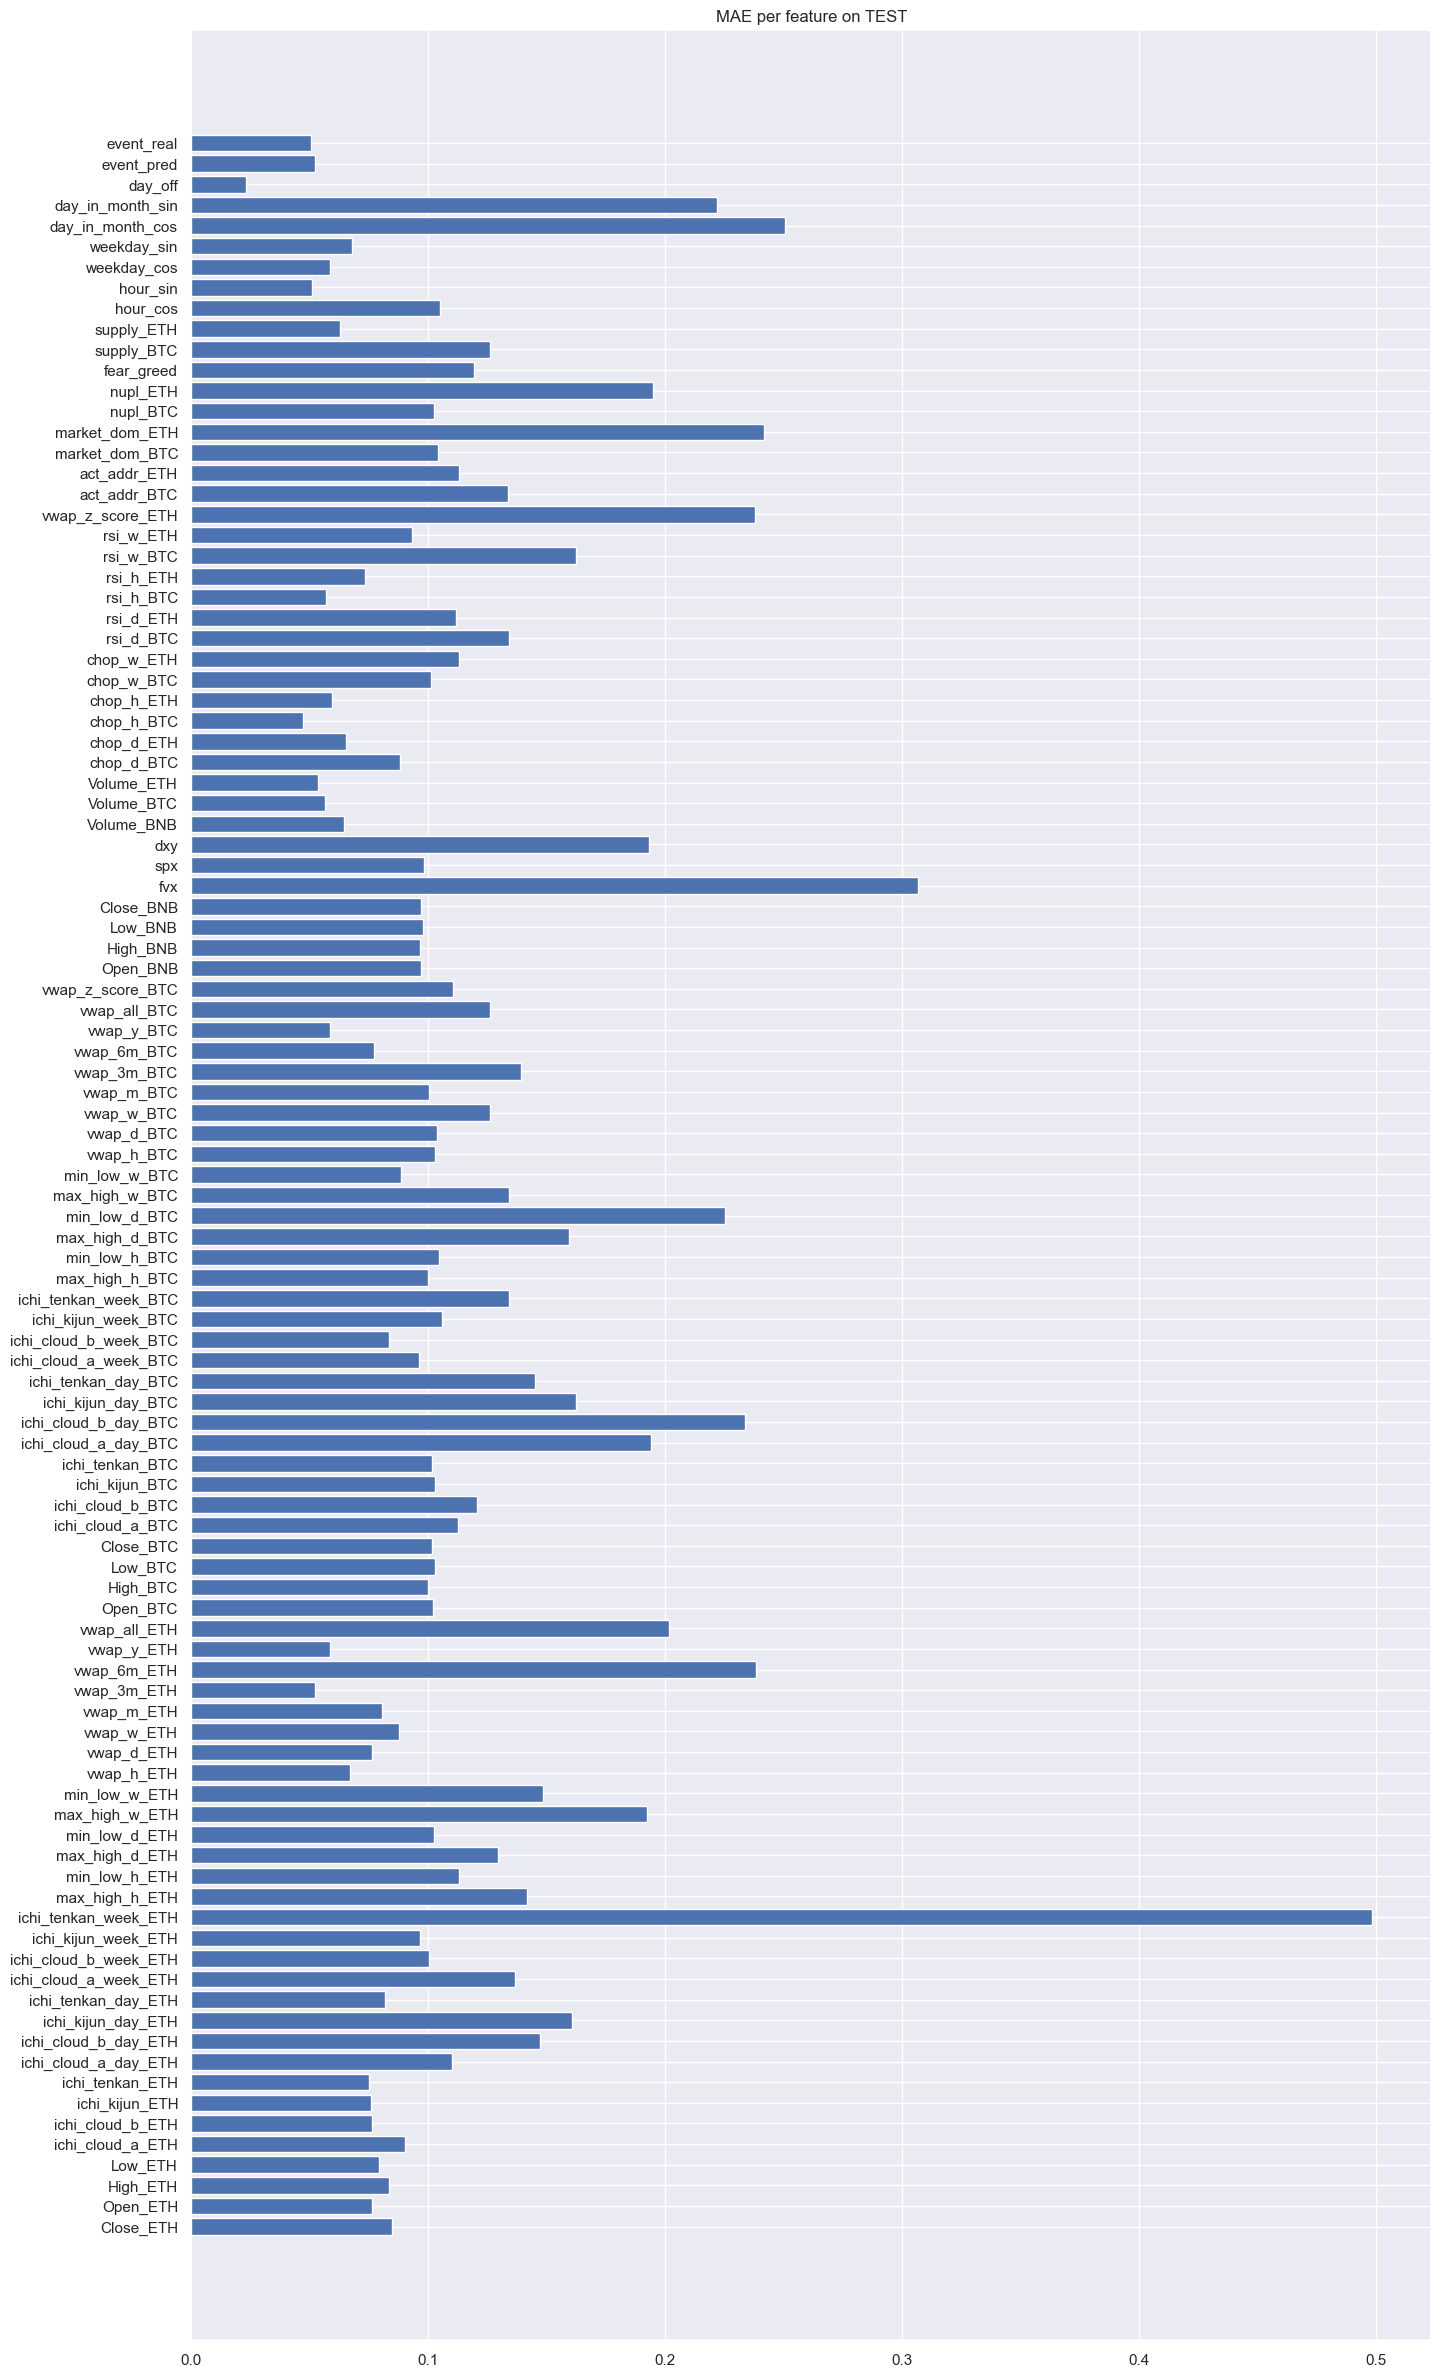

In [118]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [119]:
df_mae_ae_test_feat.values[0]

array([0.08485967, 0.07641097, 0.0835569 , 0.07923218, 0.09001054,
       0.07625356, 0.0760111 , 0.07482173, 0.11012795, 0.14694637,
       0.1607765 , 0.08171127, 0.13654595, 0.10010133, 0.09635582,
       0.49827261, 0.14168934, 0.11293385, 0.12952236, 0.10245472,
       0.19244512, 0.14845834, 0.06710648, 0.07624827, 0.08780196,
       0.08041952, 0.05233672, 0.23809152, 0.05833405, 0.20164847,
       0.10208952, 0.09988167, 0.10289545, 0.10160734, 0.11244587,
       0.12054895, 0.10302043, 0.10158776, 0.19408498, 0.23376274,
       0.16237882, 0.14480831, 0.09611574, 0.08354164, 0.10592391,
       0.13411632, 0.09993314, 0.10447629, 0.15917693, 0.2253124 ,
       0.13388459, 0.08853851, 0.1028297 , 0.10375824, 0.12599905,
       0.10046011, 0.13894681, 0.07707869, 0.05845642, 0.12614199,
       0.11044828, 0.09672891, 0.09627495, 0.09767942, 0.09686292,
       0.30672064, 0.09832146, 0.19323368, 0.06421699, 0.05643615,
       0.05349225, 0.0880036 , 0.06547027, 0.04719477, 0.05946

In [120]:
2/df_mae_ae_test_feat.values[0].sum()

0.16671686124168428

In [121]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.087699
1       TRAIN   Close_ETH  0.063385
2       TRAIN   Close_ETH  0.054499
3       TRAIN   Close_ETH  0.055133
4       TRAIN   Close_ETH  0.051397
...       ...         ...       ...
14683    TEST  event_real  0.045351
14684    TEST  event_real  0.045333
14685    TEST  event_real  0.045490
14686    TEST  event_real  0.045457
14687    TEST  event_real  0.045565

[14688 rows x 3 columns]

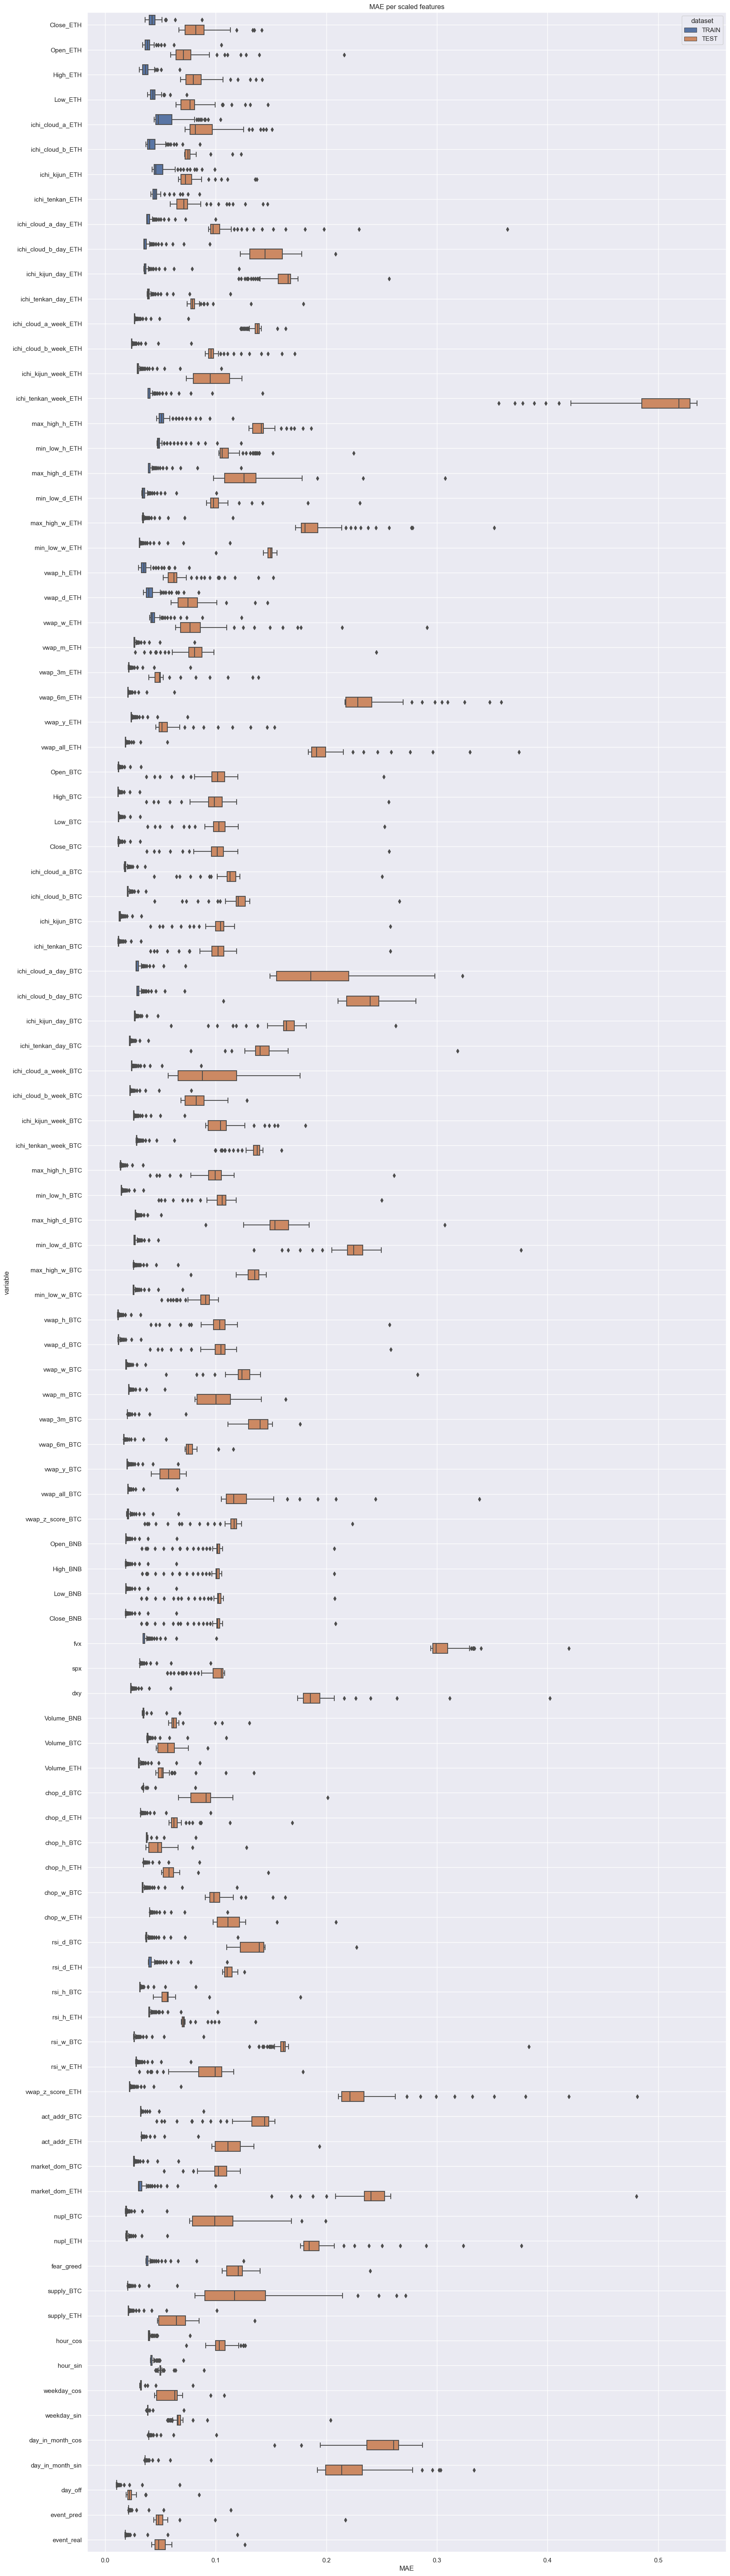

In [122]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [123]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(91325, 72, 102)
(91325, 72, 102)
(72, 102)
(371, 72, 102)
(371, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [124]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.003931  0.003508  0.003070  0.004333          0.006230   
0   0.012119  0.010873  0.011157  0.011740          0.017151   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.003849        0.005853         0.004957              0.003012   
0          0.010351        0.011274         0.010072              0.021513   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.002681  ...  0.002619  0.002871     0.002115     0.002759   
0              0.038817  ...  0.013767  0.004319     0.014933     0.006550   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.002750          0.002325  0.000777    0.001401    0.001499   
0          0.081319          0.077722  0.002212    0.010025    0.028895   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

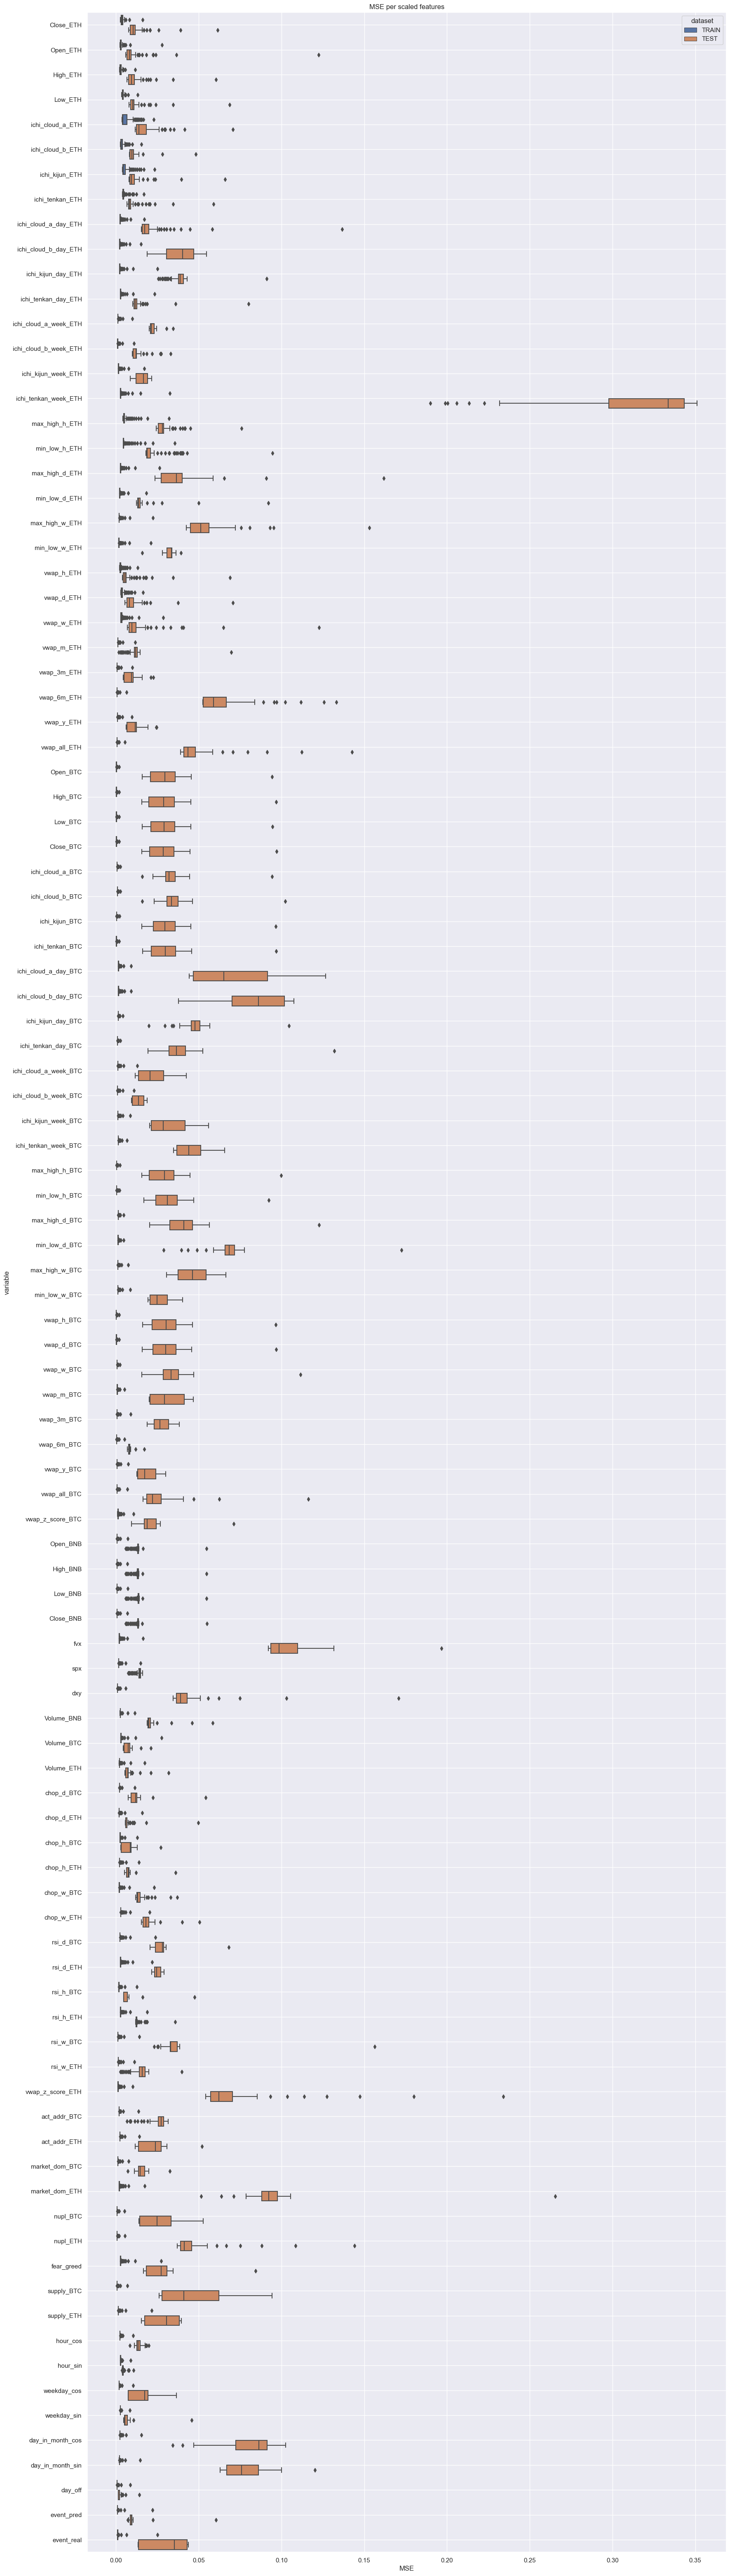

In [125]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

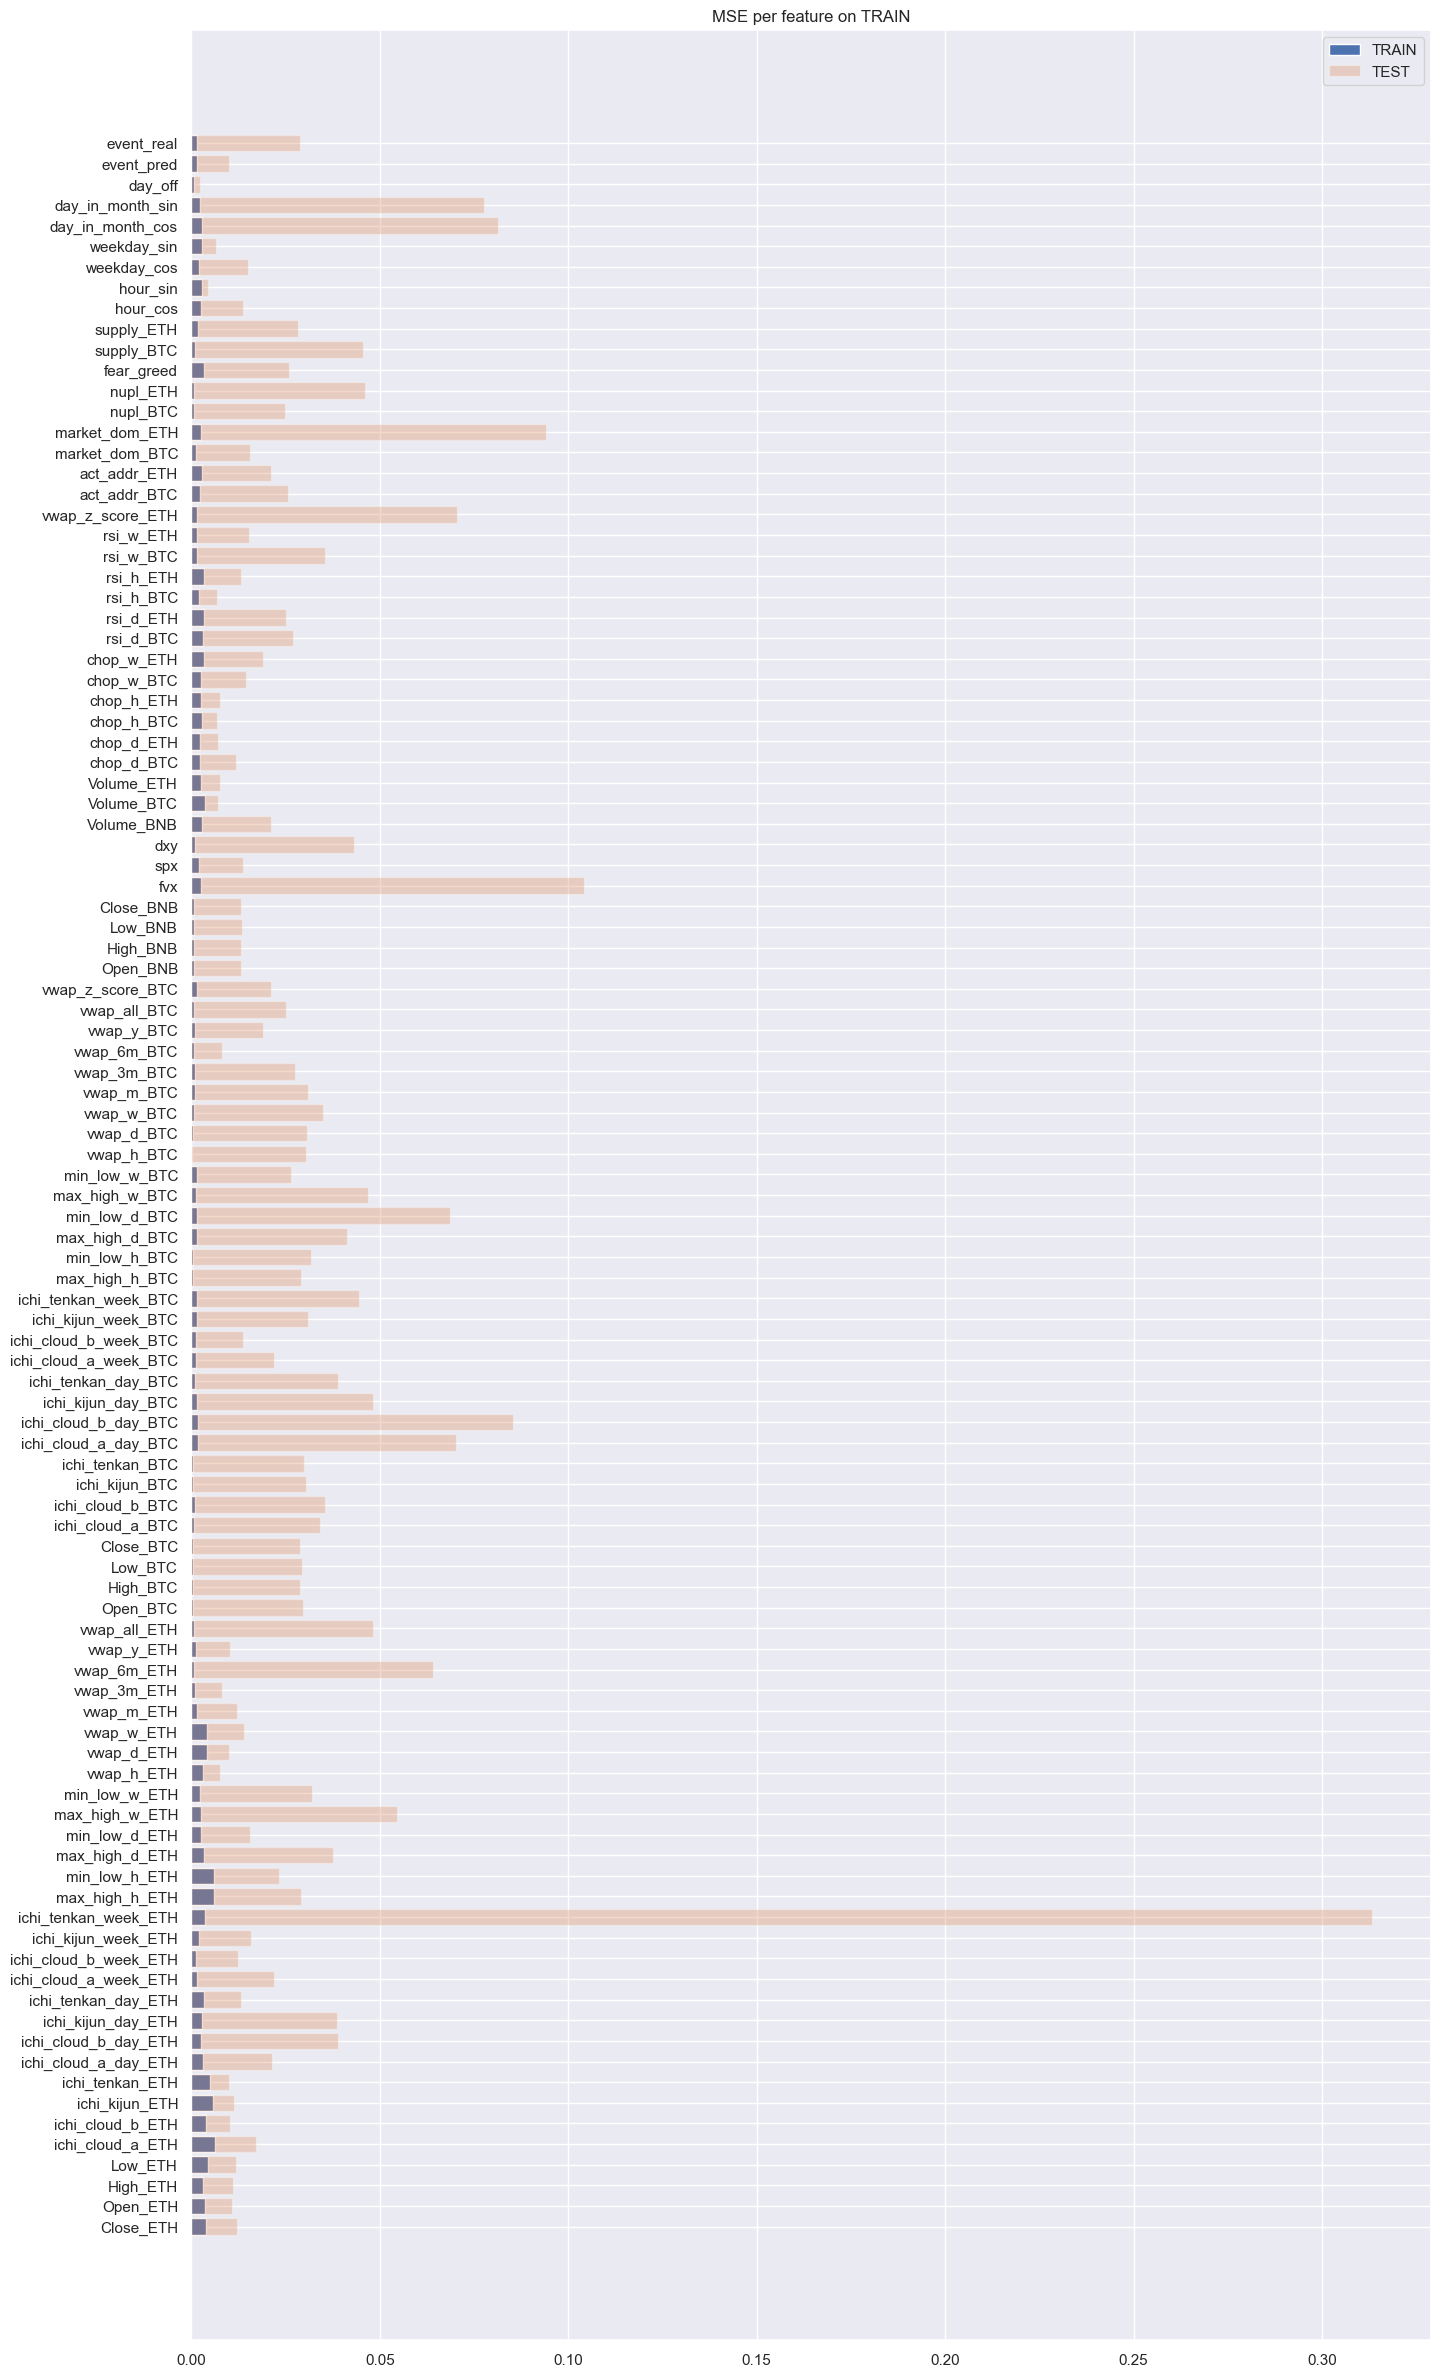

In [126]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [127]:
encoder_model.layers[3].get_weights()

[array([[ 0.02699441, -0.10137218, -0.04912986, ..., -0.05329625,
          0.04484833,  0.20509435],
        [-0.01301819, -0.01682412, -0.17347951, ..., -0.11915755,
         -0.15238734, -0.01916485],
        [ 0.1571445 , -0.08141288, -0.04442471, ...,  0.06646254,
         -0.06776934, -0.12958893],
        ...,
        [-0.06151916,  0.07156306,  0.09635377, ..., -0.06690929,
          0.062001  ,  0.05152226],
        [ 0.28490442,  0.22904572,  0.13025844, ..., -0.07987731,
         -0.02505508, -0.10059795],
        [ 0.12252034,  0.2075806 , -0.27023622, ..., -0.04362592,
         -0.1257987 ,  0.23289746]], dtype=float32),
 array([-2.64178440e-02, -2.73193419e-02,  3.46902497e-02, -1.15676560e-01,
         7.68268928e-02, -1.16067147e-02, -7.53809810e-02,  1.04902156e-01,
        -6.02025799e-02,  3.14854026e-01,  1.32006034e-01, -9.78506282e-02,
        -6.91170245e-02,  5.02726287e-02, -2.09638961e-02,  3.56252119e-02,
         2.05578562e-02,  2.57846143e-04,  2.43568011e

## Prediction Models

### LSTM all features

In [128]:
X_train_sca.shape

(91325, 72, 102)

In [129]:
X_train_sca.shape[-1]

102

In [130]:
X_train_sca.shape[-2:]

(72, 102)

In [131]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    PATIENCE_PRED = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=PATIENCE_PRED,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if PATIENCE_PRED == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [132]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2854/2854 [==============================] - 37s 13ms/step


(91325, 72, 32)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

12/12 [==============================] - 0s 25ms/step


(371, 72, 32)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((91325, 72, 36), (371, 72, 36))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



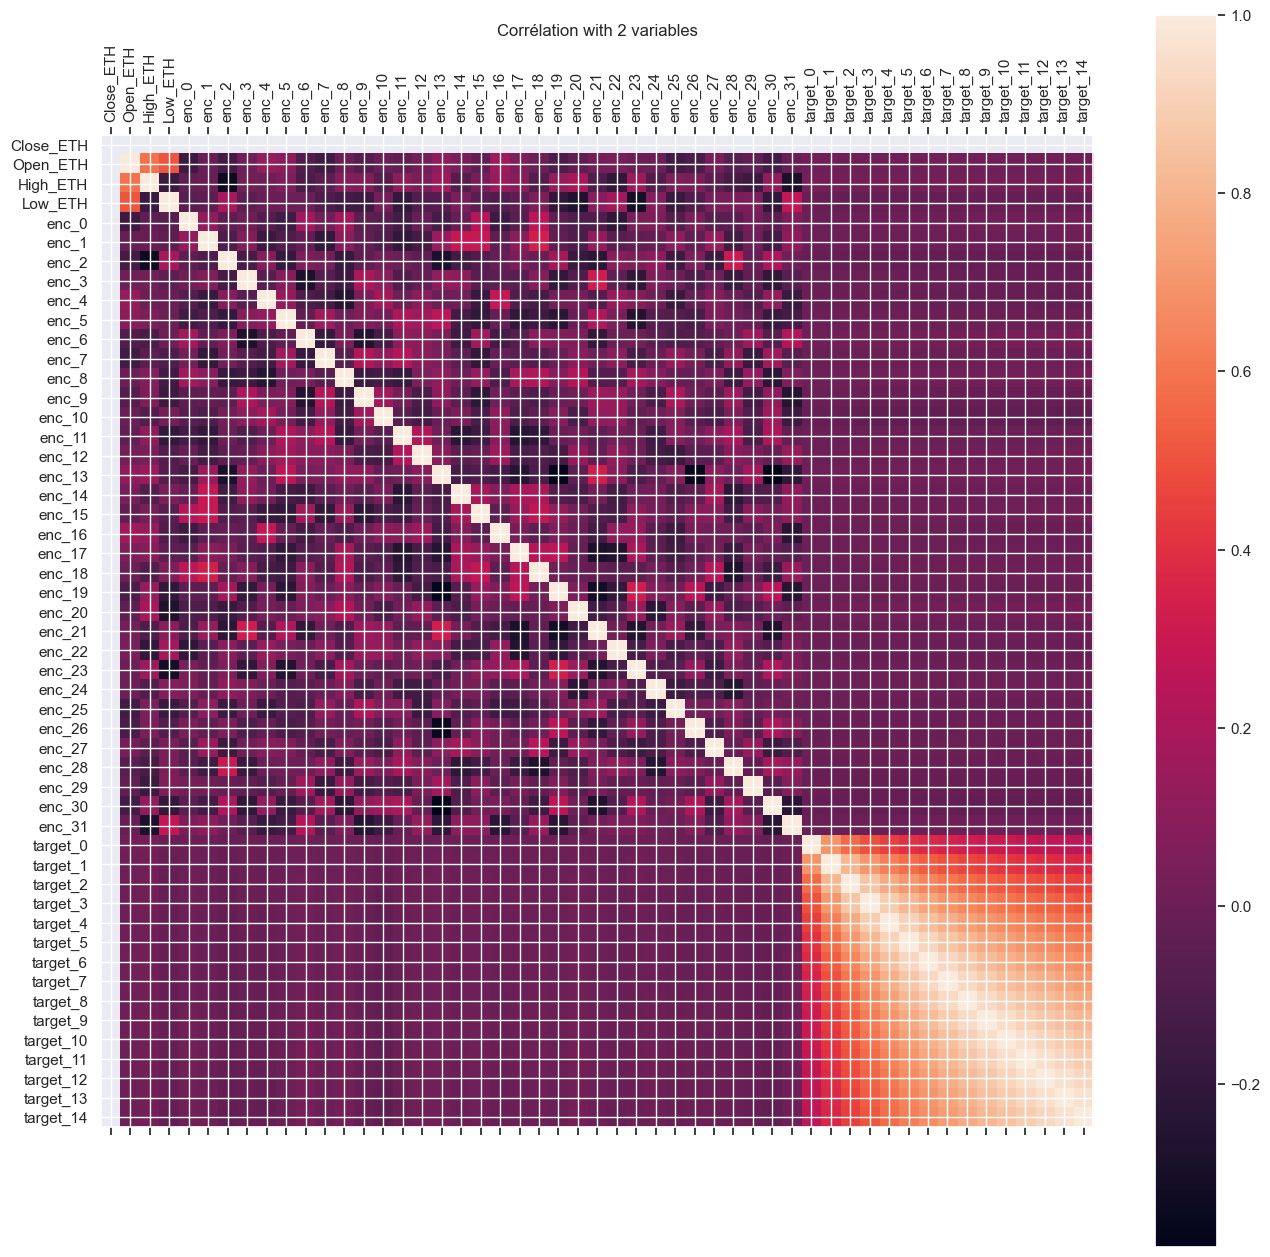

In [140]:
fig = plot_corr(corr_matrix_min)

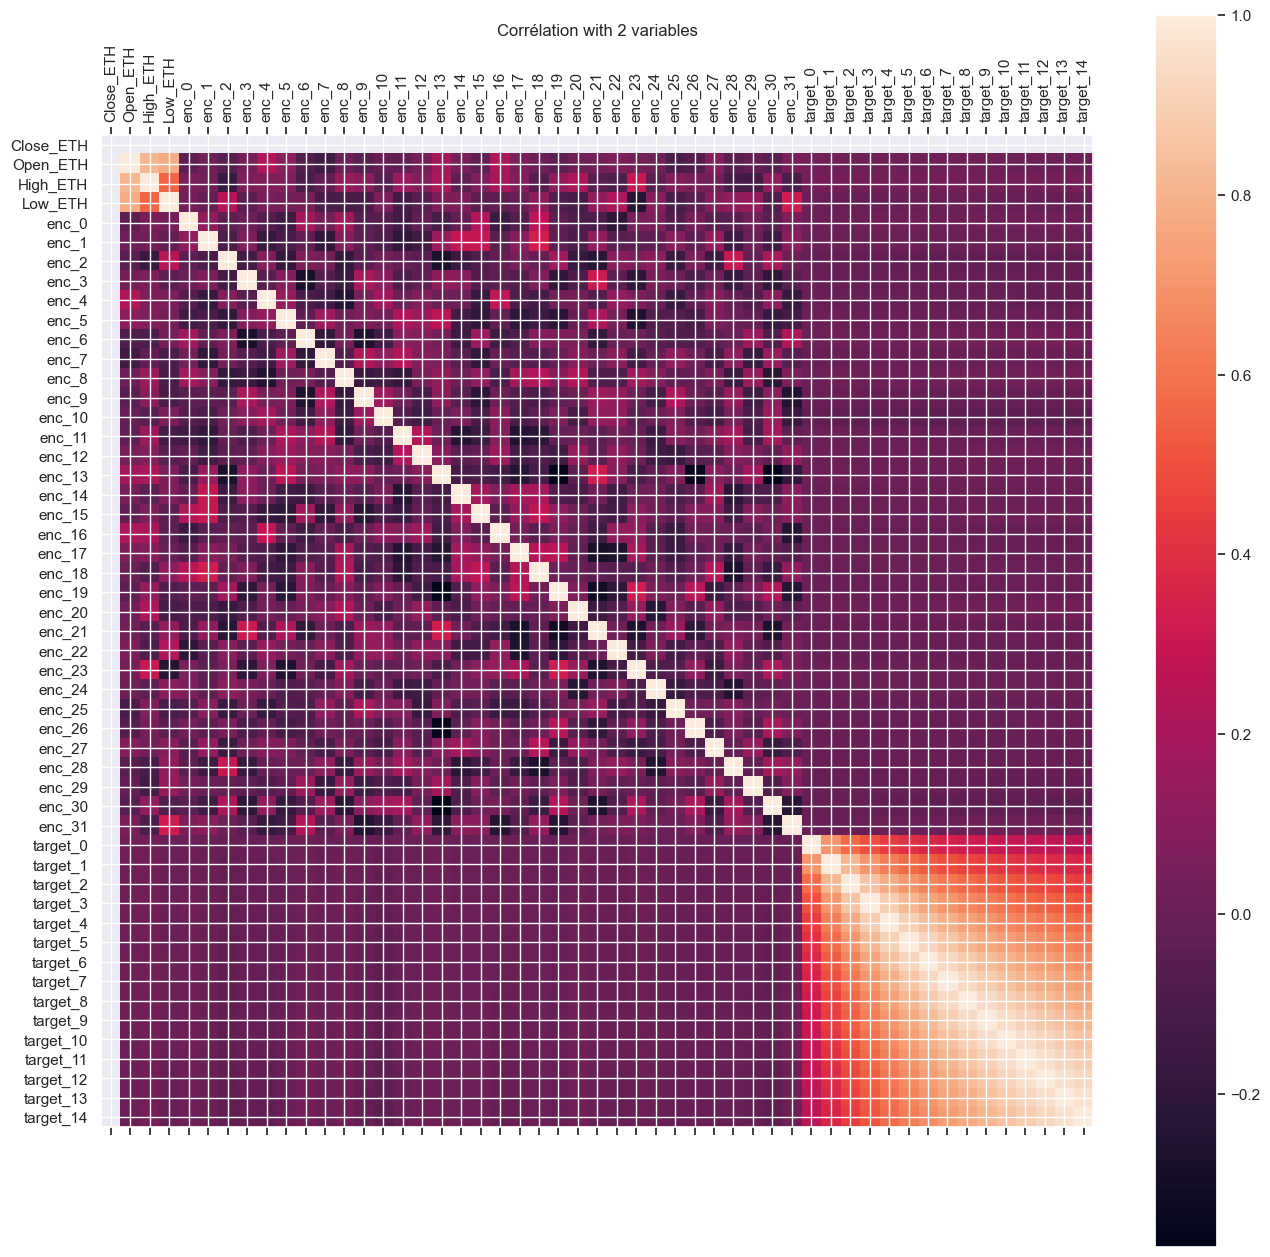

In [141]:
fig = plot_corr(corr_matrix_max) 

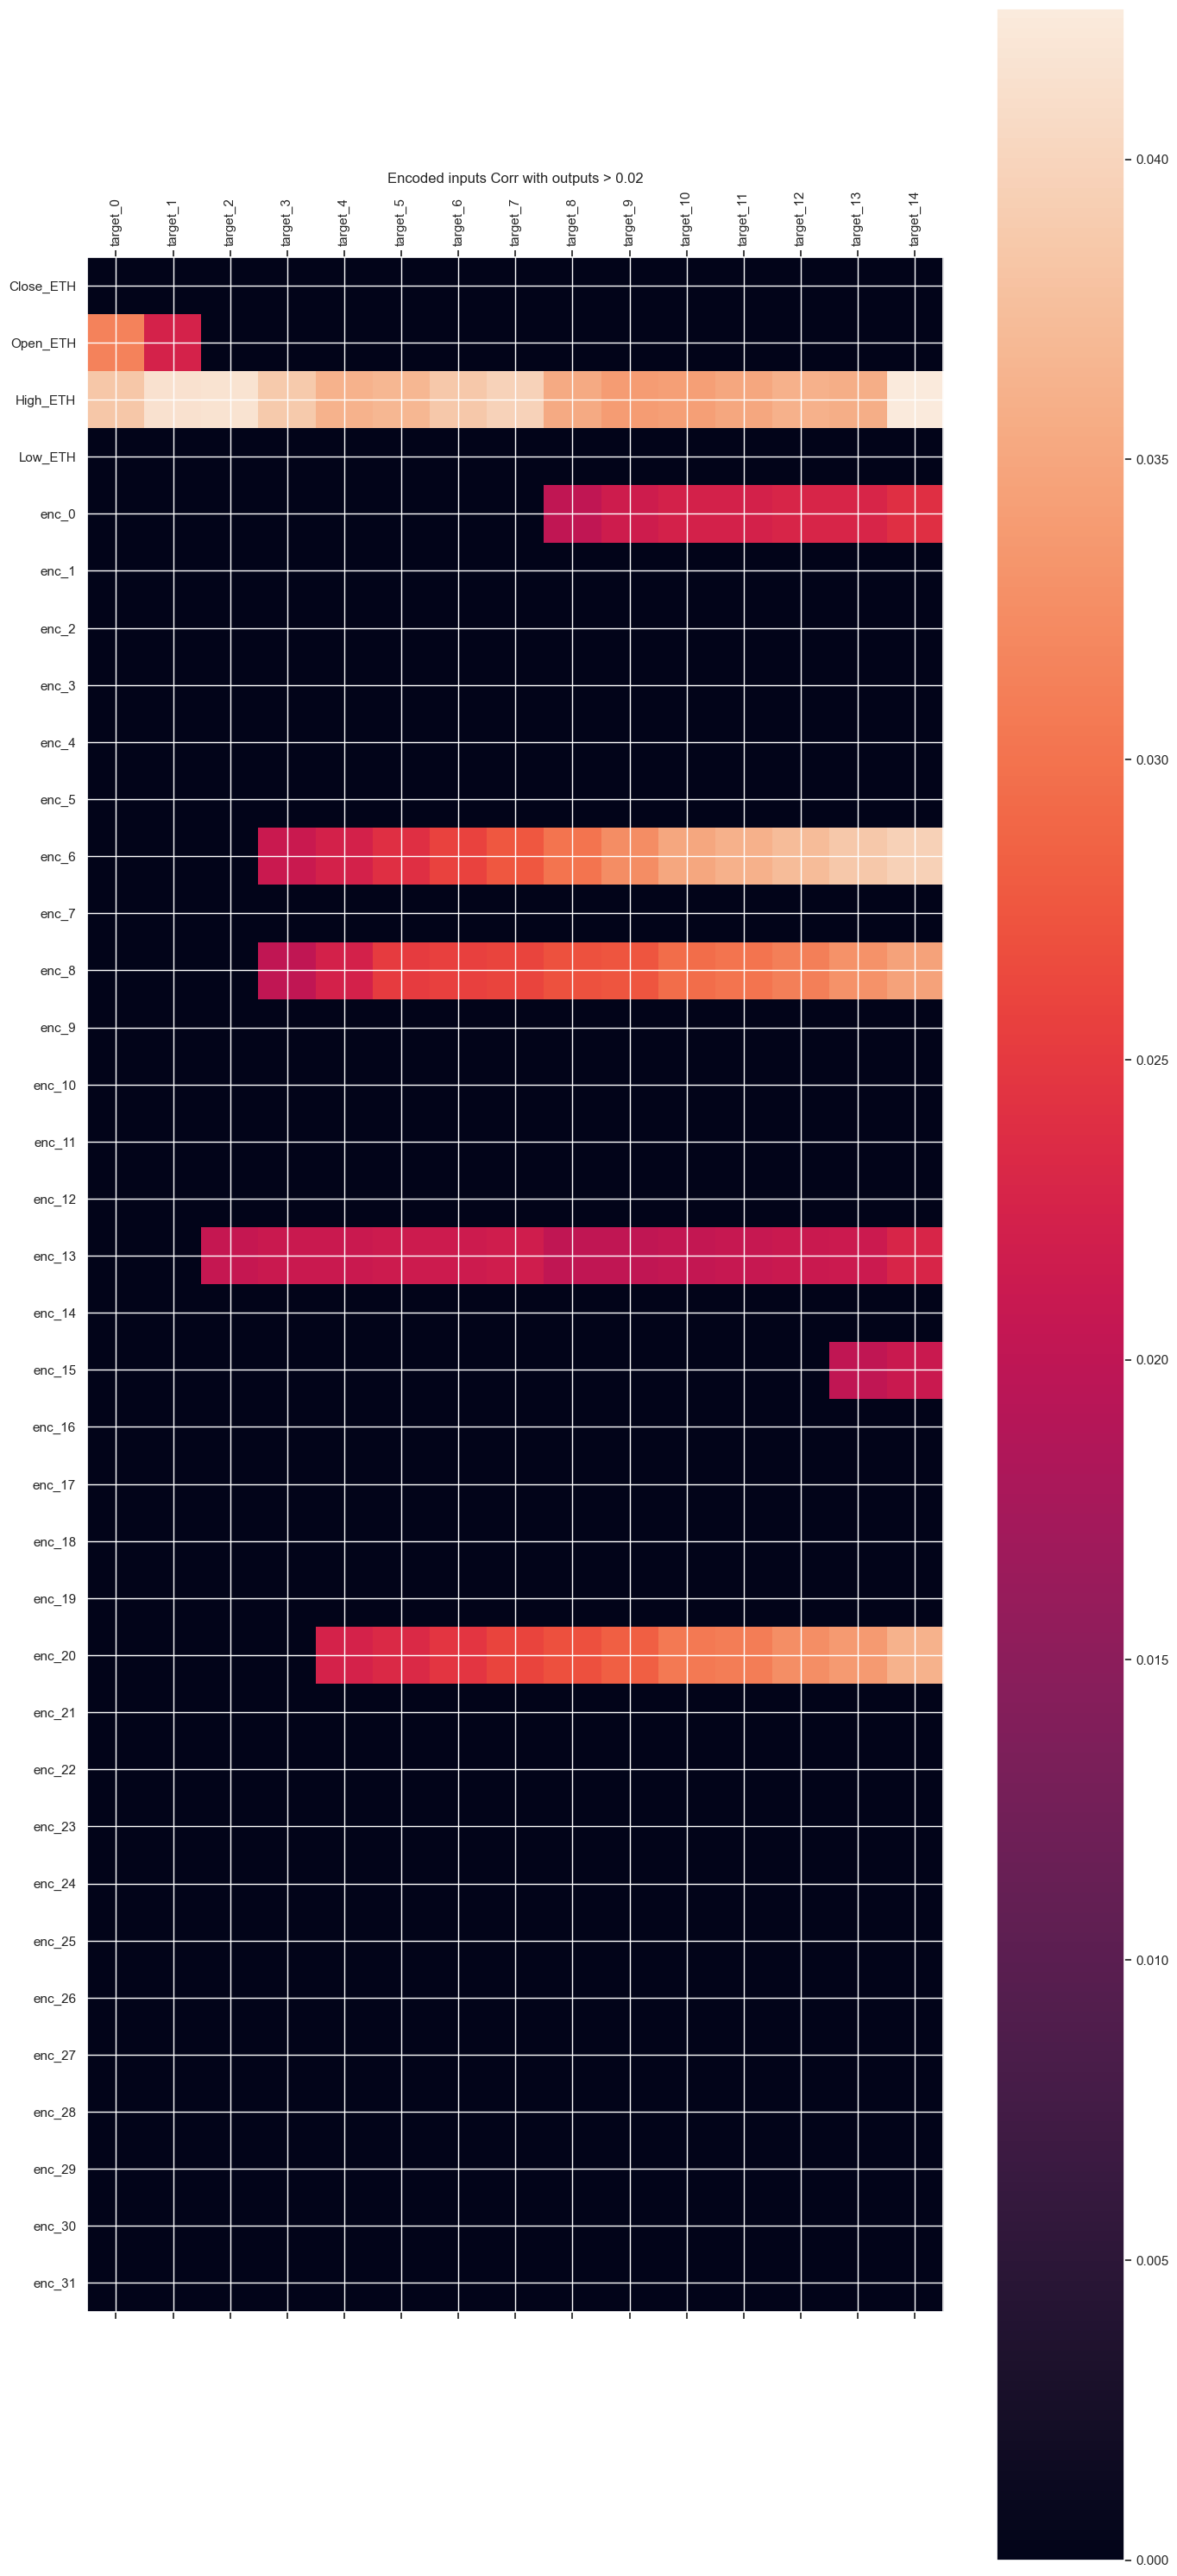

In [142]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

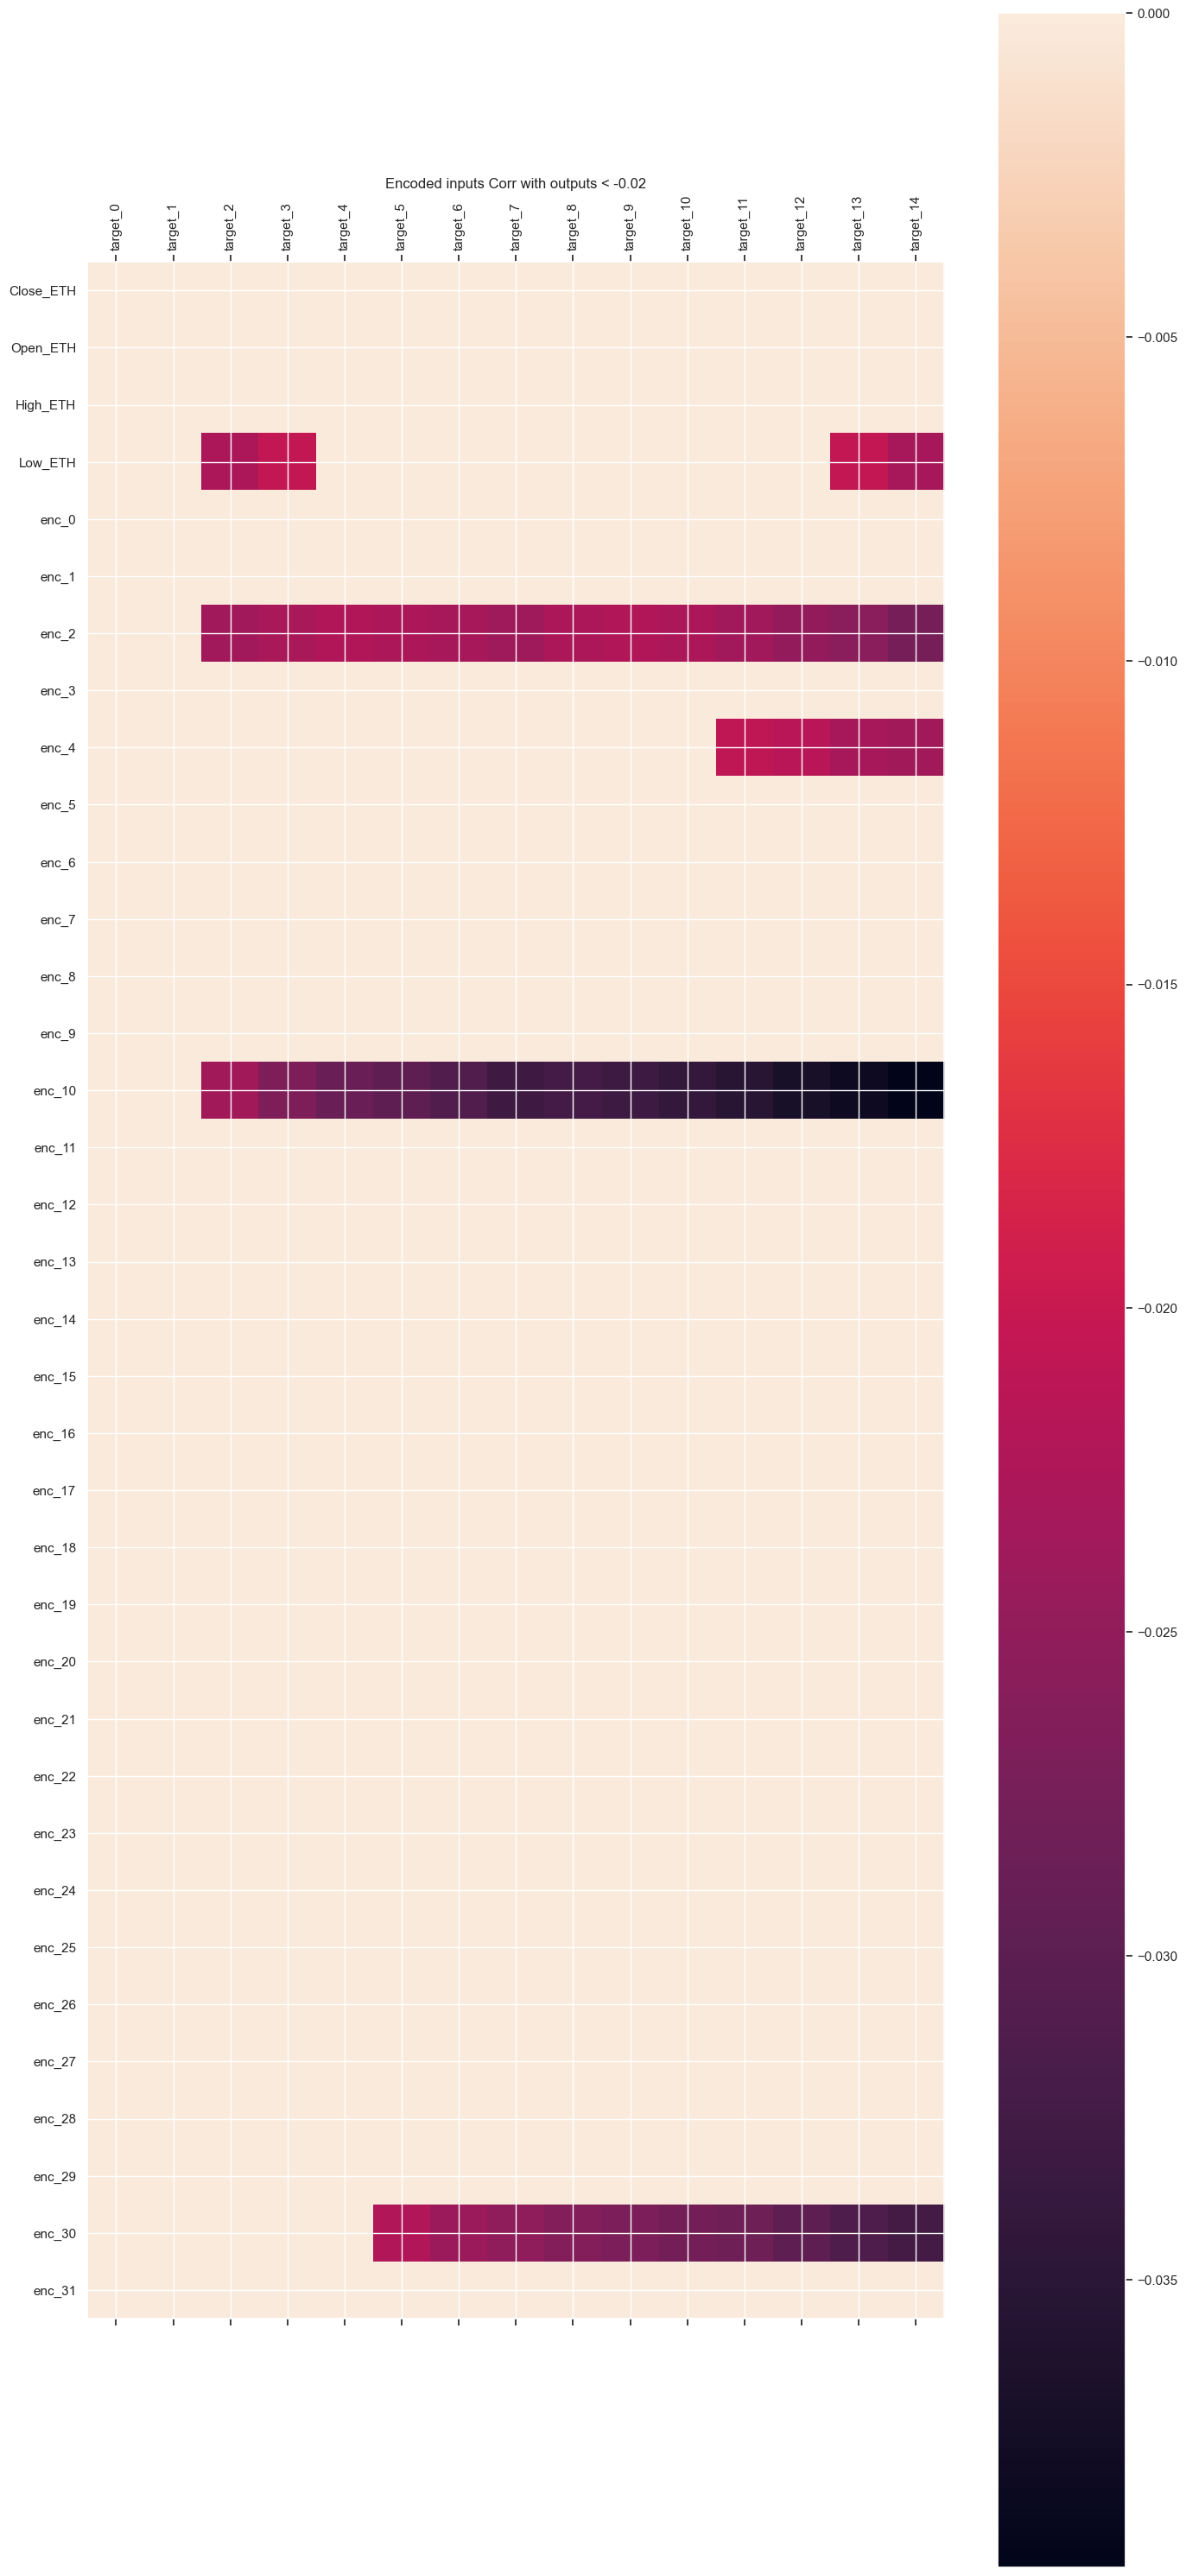

In [143]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [144]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [145]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [146]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [147]:
MODE_AUTO_SELECT

0

In [148]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
nb encoded features:  32


In [149]:
X_train_.shape

(91325, 72, 36)

In [150]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [151]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [152]:
X_train_.shape

(91325, 72, 36)

#### Train

In [153]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in LIST_UNITS_PRED: #[32, 64, 128]: #[128]: #
        for dropout_rate in  LIST_DROPOUT_PRED: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if PATIENCE_PRED is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=PATIENCE_PRED,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if PATIENCE_PRED == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                if PATIENCE_PRED !=0:
                    # mode min val loss
                    i_epoch = np.argmin(multi_step_history.history['val_loss'])
                    mse_curr_train = multi_step_history.history['loss'][i_epoch]
                    mse_curr = multi_step_history.history['val_loss'][i_epoch]
                else:
                    # mode last
                    mse_curr_train = multi_step_history.history['loss'][-1]
                    mse_curr = multi_step_history.history['val_loss'][-1]

                print("MSE TRAIN : ", mse_curr_train)
                print("MSE TEST : ", mse_curr)
                    
                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=512 / dropout= 0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1124352   
                                                                 
 layer_normalization (Layer  (None, 512)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 15)                7695      
                                                                 
Total params: 1133071 (4.32 MB)
Trainable params: 1133071 (4.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
No

In [154]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=512 / dropout= 0.2


In [155]:
np.min(y_train)

0.8990060972444147

In [156]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [157]:
X_train_.shape

(91325, 72, 36)

##### Predict

In [158]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

12/12 [==============================] - 0s 22ms/step


##### Plots

In [159]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(91335,)
(91335,)


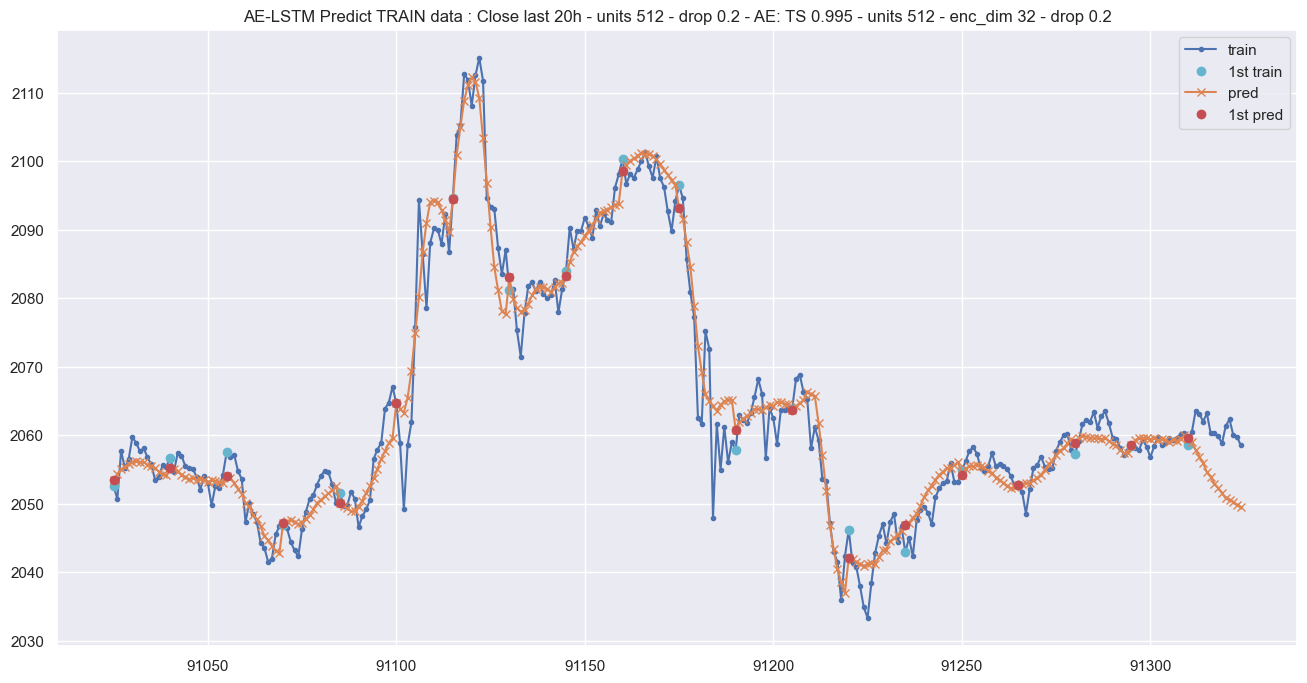

In [160]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

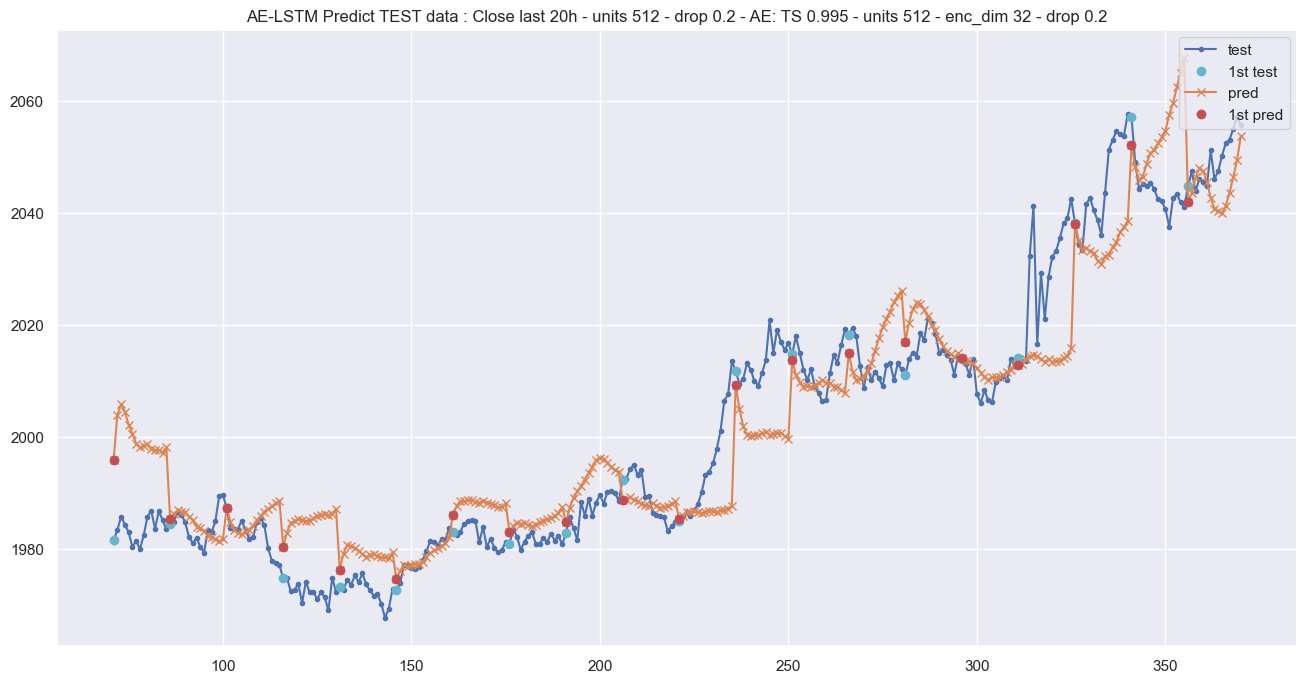

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

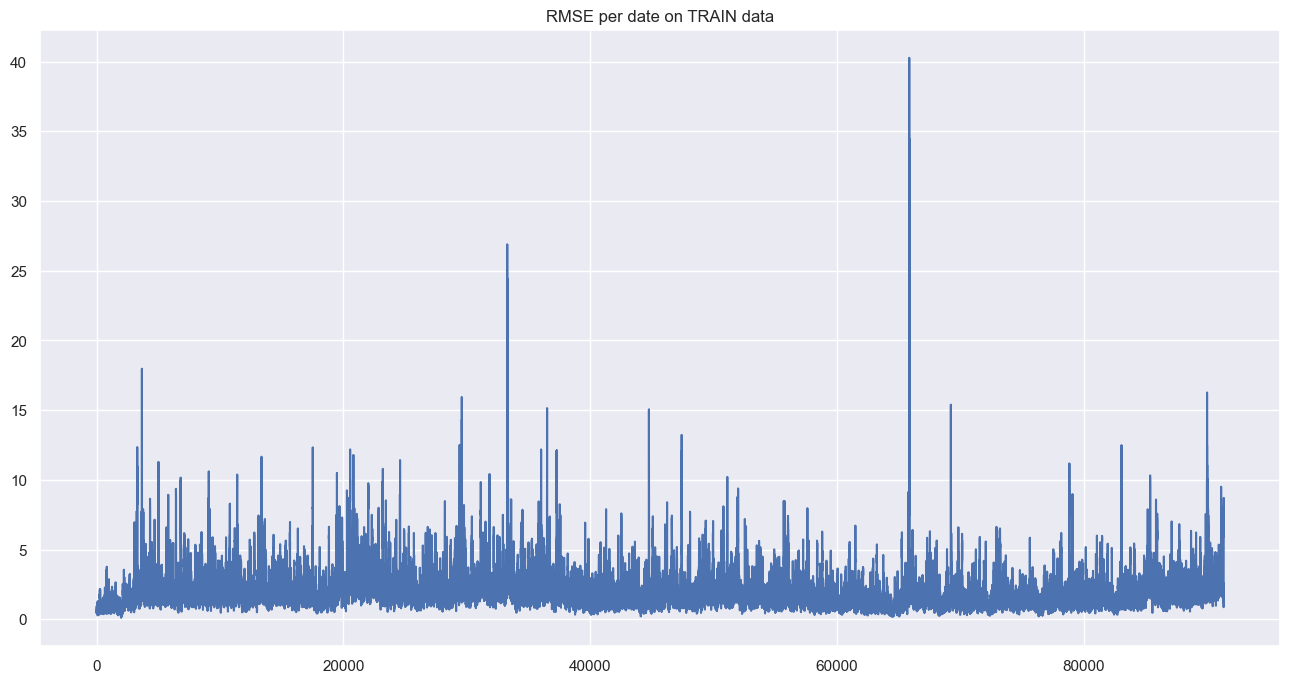

In [162]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

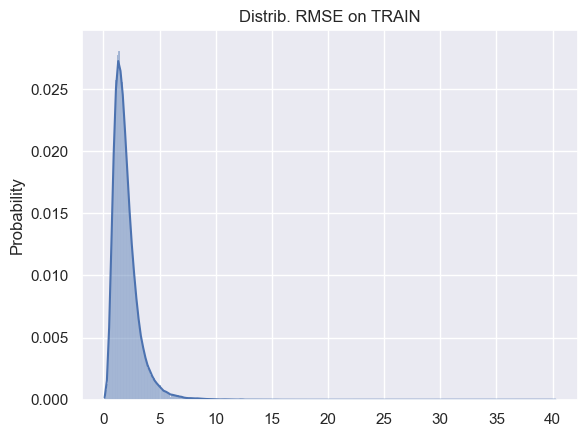

In [163]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 2.02')

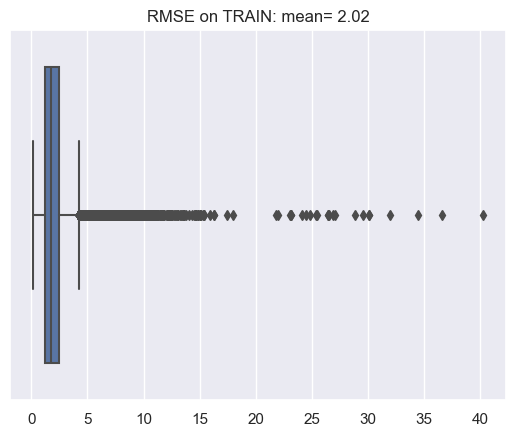

In [164]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

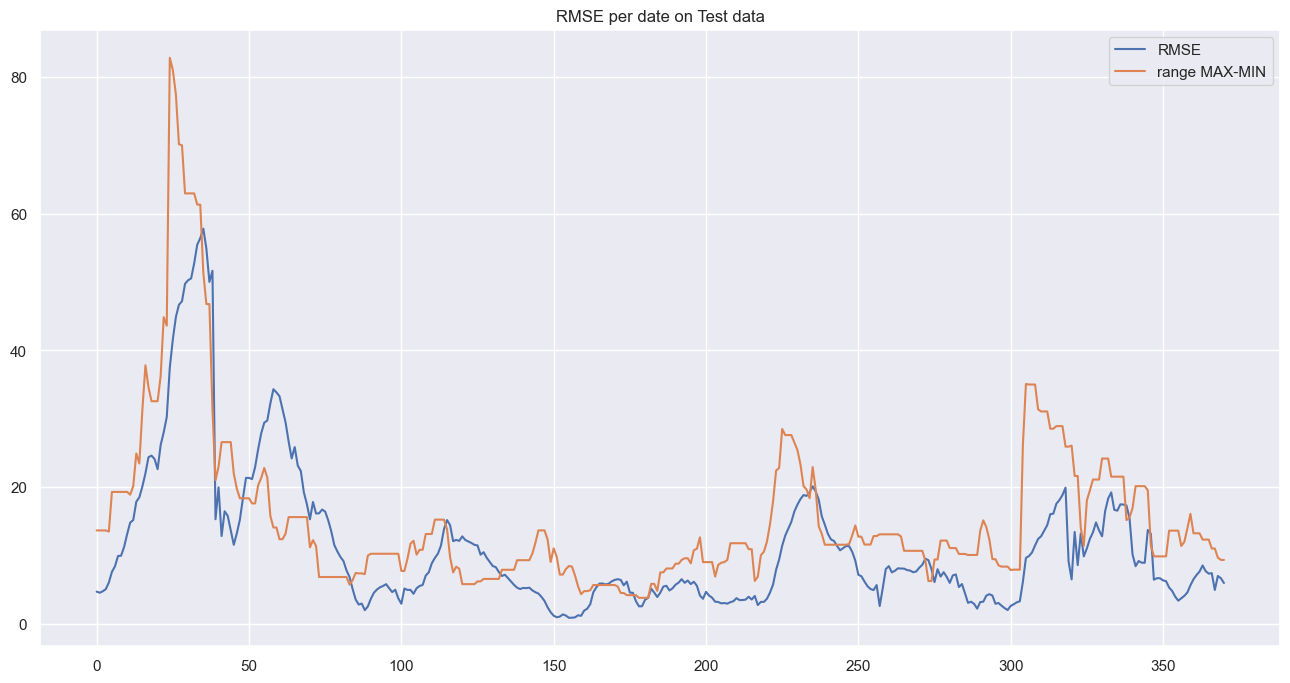

In [165]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [166]:
np.mean(arr_range)

15.678140161725082

<Axes: ylabel='Probability'>

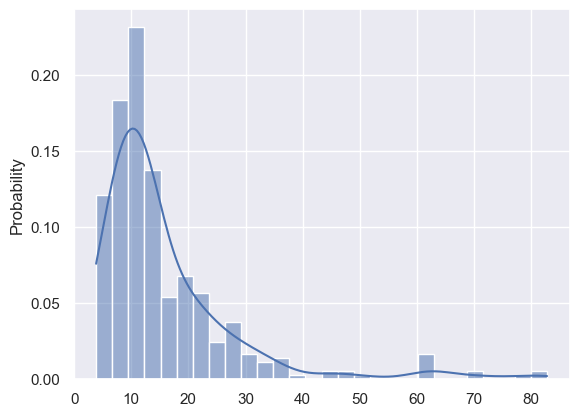

In [167]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [168]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

13.862048098460098

<Axes: ylabel='Probability'>

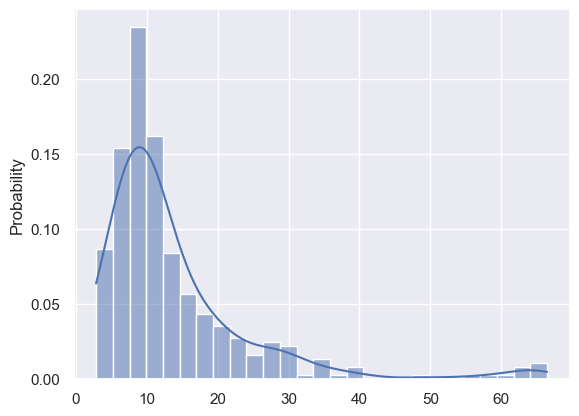

In [169]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

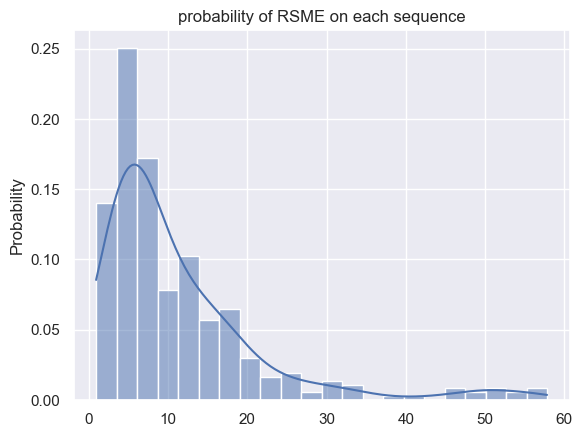

In [170]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 78.39070080862541)

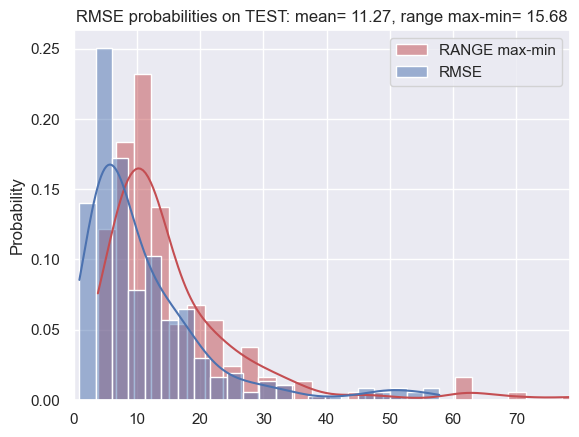

In [171]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 56.3345395461715)

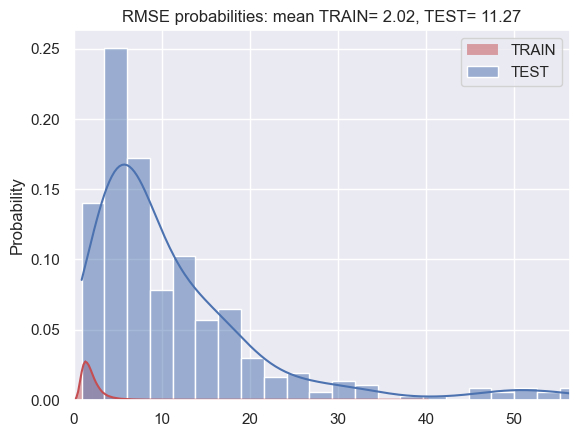

In [172]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 11.27')

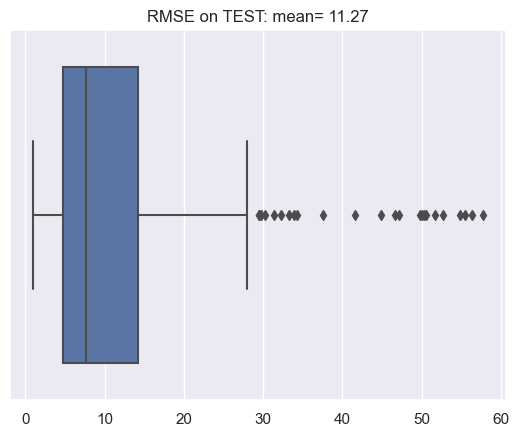

In [173]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [174]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[2047.42 2050.2  2052.43 2053.03 2055.01 2057.13 2055.76 2052.81 2051.16
 2049.77 2048.92 2047.75 2048.04 2049.88 2055.  ]
[2043.37501877 2042.25436626 2042.88353661 2043.95845566 2044.82373257
 2045.31997101 2044.77068176 2045.05532677 2045.44997597 2045.52632034
 2046.56270134 2047.06613518 2048.12763908 2049.6359893  2052.13193817]


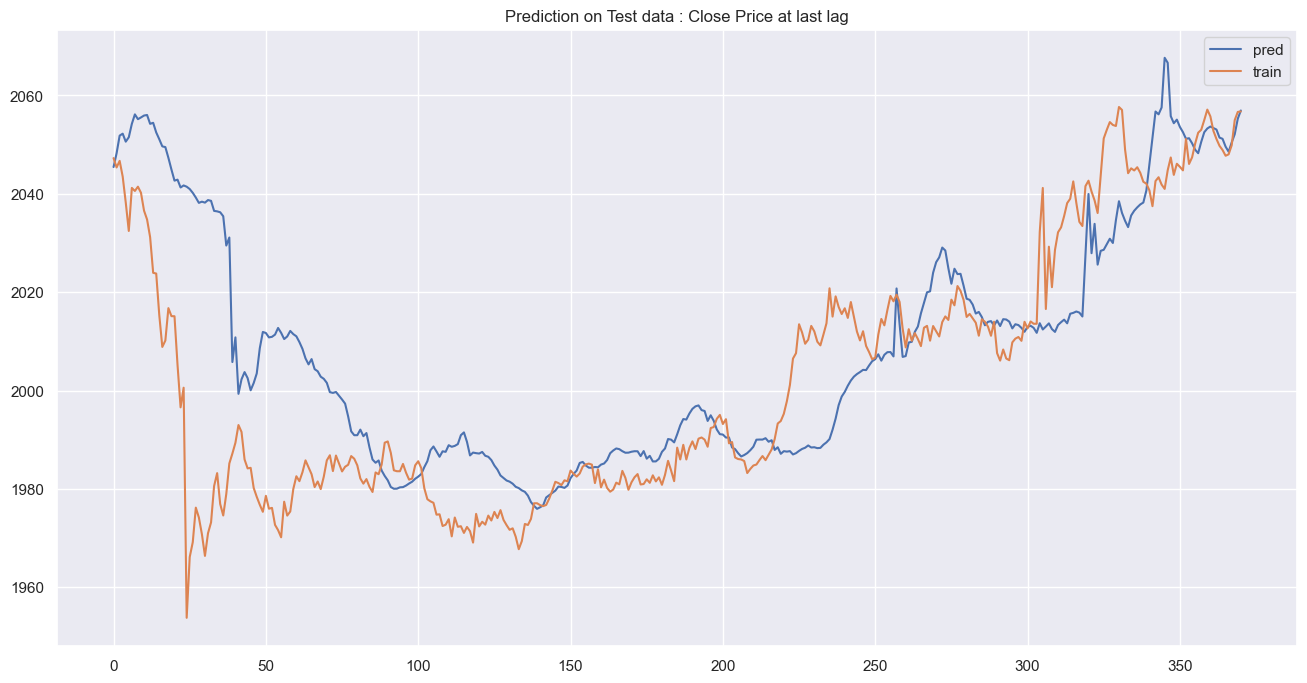

In [175]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

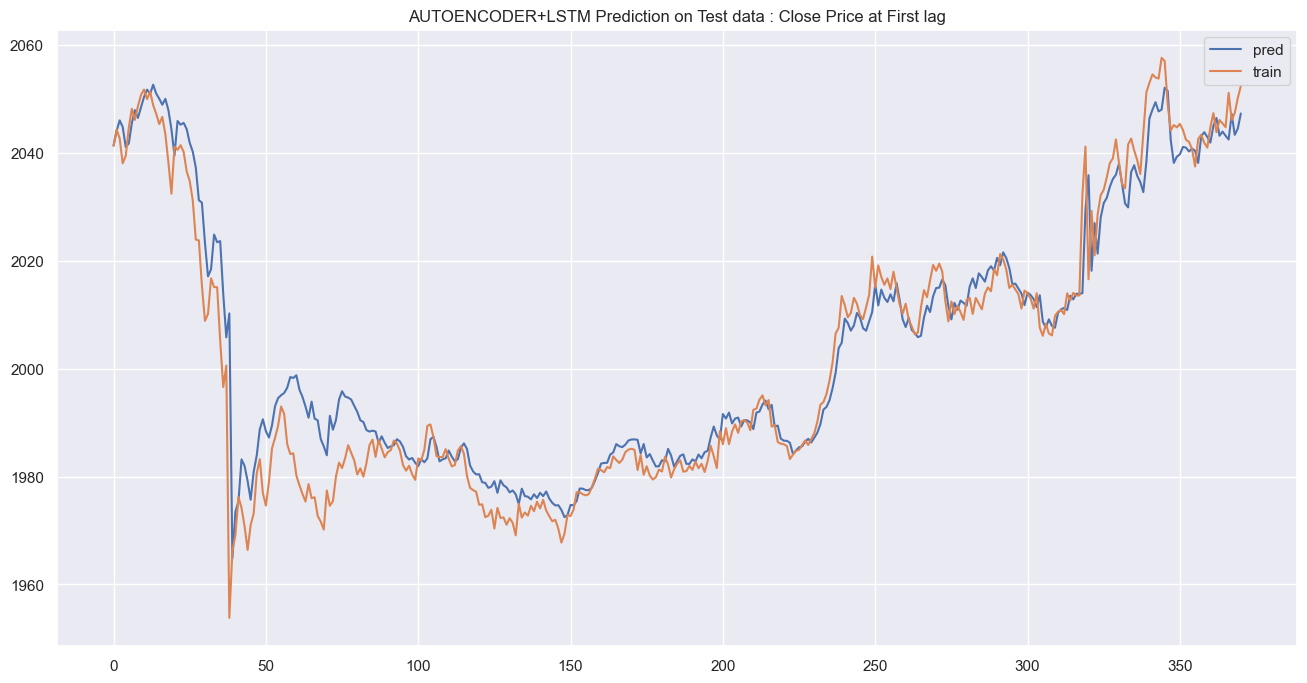

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

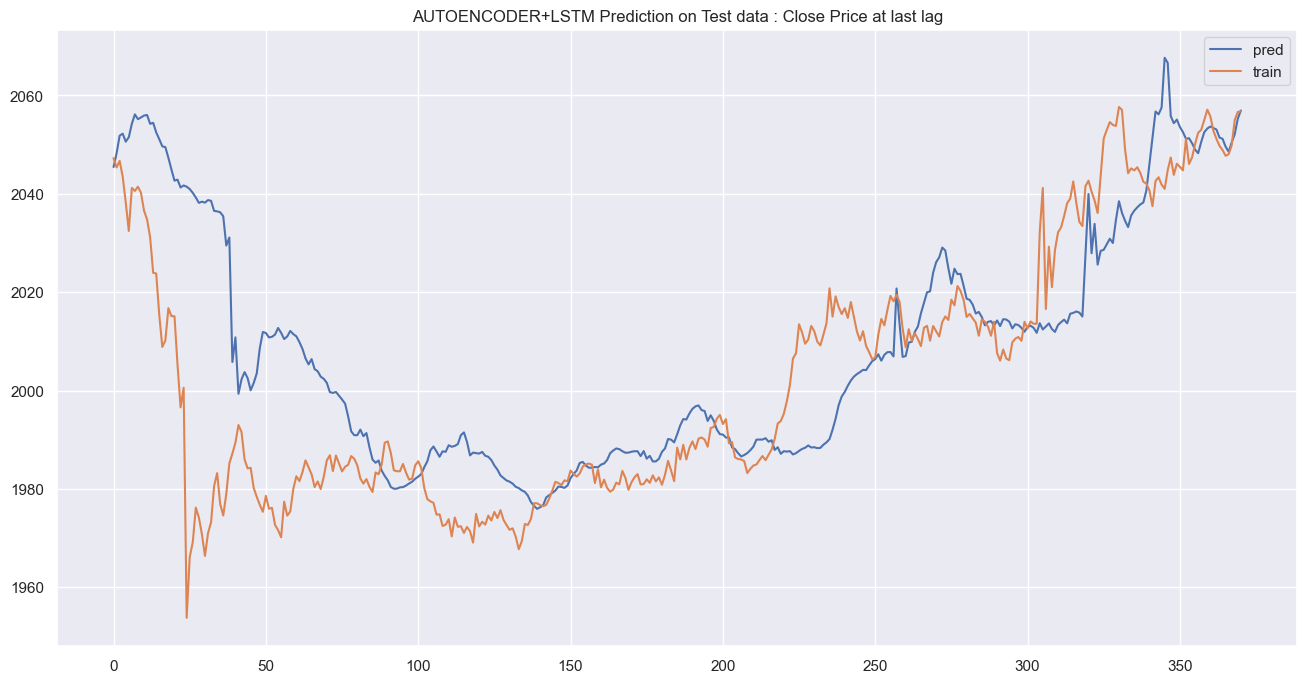

In [177]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [178]:
X_test_sca.shape

(371, 72, 102)

In [179]:
df_feat["Close_ETH"].iloc[-1]

2056.38

In [180]:
df_feat["Close_ETH"].iloc[-1]

2056.38

In [181]:
len(list_i_enc_select)

32

In [182]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[2012.64 2014.06 2013.59 2013.59 2032.24 2041.2  2016.59 2029.26 2021.03
 2028.6  2032.19 2033.19 2035.48 2038.12 2039.01 2042.53 2038.18 2034.31
 2033.46 2041.57 2042.68 2040.47 2038.67 2036.11 2043.63 2051.27 2053.01
 2054.59 2054.01 2053.8  2057.66 2057.06 2049.02 2044.2  2045.19 2044.76
 2045.41 2044.27 2042.46 2042.07 2040.7  2037.5  2042.61 2043.38 2041.88
 2041.01 2044.8  2047.4  2043.86 2046.12 2045.5  2044.78 2051.16 2046.08
 2047.42 2050.2  2052.43 2053.03 2055.01 2057.13 2055.76 2052.81 2051.16
 2049.77 2048.92 2047.75 2048.04 2049.88 2055.   2056.66 2056.75 2056.38]
X_last[0,:,0] after divide by price:
[0.97872961 0.97942015 0.97919159 0.97919159 0.98826092 0.9926181
 0.98065046 0.98681178 0.9828096  0.98649082 0.98823661 0.9887229
 0.98983651 0.99112032 0.99155312 0.99326486 0.9911495  0.98926755
 0.9888542  0.99279802 0.99333781 0.9922631  0.99138778 0.99014287
 0.99379978 0.99751505 0.9983612  0.99912954 0.99884749 0.99874537
 1.000

In [183]:
X_last_encoded_sca.shape

(1, 72, 32)

In [184]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [185]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 32)

In [186]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [187]:
X_train_.shape

(91325, 72, 36)

In [188]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
91865  1700090700000   2048.03   2050.03  2048.03    2049.88    618.5052   
91866  1700091000000   2049.88   2055.00  2049.87    2055.00    825.9691   
91867  1700091300000   2055.00   2056.66  2052.87    2056.66    813.5290   
91868  1700091600000   2056.65   2060.00  2056.31    2056.75   1027.9829   
91869  1700091900000   2056.74   2057.30  2056.38    2056.38     85.2793   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1736.899212       1736.445752   
1      2023-01-01 00:05:00       1736.899212       1736.445752   
2      2023-01-01 00:10:00       1736.899212       1736.445752   
3      2023-01-01 00:15:00       1736.899212       1736.445752   
4      2023-01-01 00:20:00       1736.899212       1736.445752   
...                    ...               ...               ...   
91865  2023-11-15 23:25:00       2044.872500       2032.115000   
91866  2023-11-15 23:30:00       2044.245000       2032.115000   
91867  2023-11-15 23:35:00       2044.245000       2032.405000   
91868  2023-11-15 23:40:00       2044.740000       2032.650000   
91869  2023-11-15 23:45:00       2045.267500       2032.650000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
91865        2048.790  ...         NaN            NaN           NaN   
91866        2049.775  ...         NaN            NaN           NaN   
91867        2049.775  ...         NaN            NaN           NaN   
91868        2049.775  ...         NaN            NaN           NaN   
91869        2050.975  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
91865               NaN         0.0               NaN         0.0      0.0   
91866               NaN         0.0               NaN         0.0      0.0   
91867               NaN         0.0               NaN         0.0      0.0   
91868               NaN         0.0               NaN         0.0      0.0   
91869               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
91865                  NaN  False  
91866                  NaN  False  
91867                  NaN  False  
91868                  NaN  False  
91869                  NaN  False  

[91870 rows x 136 columns]

In [189]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [190]:
y_last_pred_unscaled

array([[0.9993067 , 0.99932766, 0.99979424, 1.000405  , 1.0007085 ,
        1.0005225 , 0.99970543, 0.9992941 , 0.999475  , 0.9996889 ,
        1.0006838 , 1.0018983 , 1.003568  , 1.0054322 , 1.0076766 ]],
      dtype=float32)

In [191]:
df_feat["Close_ETH"].iloc[-1]

2056.38

In [192]:
y_last_pred_raw

array([[2054.954 , 2054.9973, 2055.9568, 2057.2126, 2057.8367, 2057.4543,
        2055.7742, 2054.9282, 2055.3003, 2055.7402, 2057.786 , 2060.2834,
        2063.717 , 2067.5505, 2072.1658]], dtype=float32)

In [193]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [194]:
list_pred

[2057.2126,
 2057.8367,
 2057.4543,
 2055.7742,
 2054.9282,
 2055.3003,
 2055.7402,
 2057.786,
 2060.2834,
 2063.717,
 2067.5505,
 2072.1658]

In [195]:
save_list(list_pred, path_save_pred_vals)

In [196]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [197]:
list_pred_reload

[2057.2126,
 2057.8367,
 2057.4543,
 2055.7742,
 2054.9282,
 2055.3003,
 2055.7402,
 2057.786,
 2060.2834,
 2063.717,
 2067.5505,
 2072.1658]